# Project 3: Subreddit Classification (Part 2 of 2)


> By:  Rohazeanti Mohamad Jenpire

## Table of Contents
- [Imports](#Imports)
- [Read Data](#Read-Data)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Pre-processing](#Pre-processing)
- [Modelling](#Modelling)
- [Evaluation](#Evaluation)
- [Conclusion & Recommendations](#Conclusion-&-Recommendations)

### Imports

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import Normalize

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display

import scikitplot as skplt
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.util import ngrams 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.display.max_columns = None

### Read Data

In [3]:
diet = pd.read_csv("diet.csv")
exercise = pd.read_csv("exercise.csv")

In [4]:
diet.shape

(3000, 4)

In [5]:
diet.head()

subreddit                                           selftext  \
0      diet                                                NaN   
1      diet                                          [removed]   
2      diet  For those of you that do not know, a fruitaria...   
3      diet                                          [removed]   
4      diet                                          [removed]   

                                               title  created_utc  
0  Best diet to lose weight before going on vacat...   1659585910  
1  Does anyone else get sick from foods you used ...   1659582639  
2                      Debunking the fruitarian diet   1659567365  
3  Is it okay if I stop eating all bread , pasta,...   1659554541  
4                                          KETO DIET   1659546069

In [6]:
exercise.shape

(3000, 4)

In [7]:
exercise.head()

subreddit selftext                                              title  \
0  Exercise      NaN  Exercise-Mediated Neurogenesis in the Hippocam...   
1  Exercise      NaN  High school in 1962. No internet, no seed oils...   
2  Exercise      NaN  Combining exercise with goal setting for great...   
3  Exercise      NaN                                                🥰🥰🥰   
4  Exercise      NaN  Neuroscientist: "If you practice this, your br...   

   created_utc  
0   1659546072  
1   1659301009  
2   1657933427  
3   1654698531  
4   1654362544

#### Combine `exercise` and `diet` dataset

In [8]:
# Combining both exercise and diet datasets into a single combined dataset
df_combined = exercise[["subreddit", "selftext", "title"]].append(diet[["subreddit", "selftext", "title"]])

In [9]:
df_combined.shape

(6000, 3)

In [10]:
# Resetting index
df_combined = df_combined.reset_index()

In [11]:
df_combined.head()

index subreddit selftext                                              title
0      0  Exercise      NaN  Exercise-Mediated Neurogenesis in the Hippocam...
1      1  Exercise      NaN  High school in 1962. No internet, no seed oils...
2      2  Exercise      NaN  Combining exercise with goal setting for great...
3      3  Exercise      NaN                                                🥰🥰🥰
4      4  Exercise      NaN  Neuroscientist: "If you practice this, your br...

In [12]:
# Drop extra index column
df_combined.drop(columns=["index"], inplace = True)

In [13]:
df_combined.tail()

subreddit                                           selftext  \
5995      diet  I drank molasses for almost 2 years to help wi...   
5996      diet  [https://milindbhandirge666.systeme.io/7f97384...   
5997      diet                                                NaN   
5998      diet  I am 17F, and I lost weight over past few year...   
5999      diet  Background: 26\n5’ 10 \n190 lbs\n18% Bodyfat\n...   

                                                  title  
5995  Should I drink molasses with water or eat it w...  
5996                                           Keto BHB  
5997  howdy how many calories are in 2 grams of psil...  
5998   How to gain weight fast when you can't eat much?  
5999                          Should I have tests done?

In [14]:
# Replacing the target "subreddit" into a binary variable. r/exercise == 1, r/diet == 0
df_combined["subreddit"] = df_combined["subreddit"].map({"Exercise": 1, "diet": 0})

In [15]:
df_combined.head()

subreddit selftext                                              title
0          1      NaN  Exercise-Mediated Neurogenesis in the Hippocam...
1          1      NaN  High school in 1962. No internet, no seed oils...
2          1      NaN  Combining exercise with goal setting for great...
3          1      NaN                                                🥰🥰🥰
4          1      NaN  Neuroscientist: "If you practice this, your br...

### Data Cleaning

#### Inspect `df_combined` data

In [16]:
#check missing data
df_combined.isnull().sum()

subreddit       0
selftext     1698
title           0
dtype: int64

In [17]:
# Looking for major reddit imputed values 
df_combined['selftext'].value_counts().head(3)

[removed]                                                                                                                                                1082
[deleted]                                                                                                                                                  26
Let's see who's more active!\nI'm tracking my steps with friends on StepUp.\nGet the app. It's fun! #HealthyCompetition\nhttp://get.thestepupapp.com/       3
Name: selftext, dtype: int64

In [18]:
# Looking for major reddit imputed values 
df_combined['title'].value_counts().head(3)

Help                                                           7
18 weight loss exercises to burn 500 calories in 30 minutes    6
I need help                                                    6
Name: title, dtype: int64

In [19]:
#check for unique posts
len(df_combined["selftext"].unique()), len(df_combined["title"].unique()), len(df_combined["subreddit"].unique())

(3177, 5780, 2)

In [20]:
#find duplicated rows, boolean series
duplicated_title = df_combined["title"].duplicated(keep=False)
duplicated_selftext = df_combined["selftext"].duplicated(keep=False)

In [21]:
#saving the index of identified duplicated rows
title_index = df_combined["title"][duplicated_title].sort_values().index
selftext_index = df_combined["selftext"][duplicated_selftext].sort_values().index

In [22]:
#print first 10 rows of duplicated rows
df_combined.loc[title_index].head(10)

subreddit   selftext                                             title
2776          1        NaN  1 year body transformation 190lb - 143lb - 160lb
2757          1        NaN  1 year body transformation 190lb - 143lb - 160lb
1907          1        NaN          10 Minute Morning Yoga Full Body Stretch
1554          1        NaN          10 Minute Morning Yoga Full Body Stretch
5182          0  [removed]            10 TIPS TO STAY HEALTHY TONE YOUR BODY
5183          0  [removed]            10 TIPS TO STAY HEALTHY TONE YOUR BODY
599           1        NaN      11 Best Exercises to get rid of Underarm Fat
859           1        NaN      11 Best Exercises to get rid of Underarm Fat
730           1        NaN      11 Best Exercises to get rid of Underarm Fat
5197          0  [removed]     11 GREEN TEA ALTERNATIVES TO LOSE WEIGHT FAST

In [23]:
#print first 10 rows of duplicated rows
df_combined.loc[selftext_index].tail(10)

subreddit selftext                                              title
5841          0      NaN  What Tea do you think is the best for fat loss...
5847          0      NaN  Is it a 1200 calories diet ok for long life term?
5905          0      NaN  Does anyone here use Weight Watchers still? If...
5917          0      NaN  Would you trust that these chickpeas have 88 c...
5945          0      NaN  How do I get my hunger under control, I strugg...
5948          0      NaN  What diet would you recommend to stay in the 1...
5962          0      NaN  Should I worry about the percent on the nutrit...
5979          0      NaN  How do you lower body fat percentage? Like wha...
5984          0      NaN  Is it possible to lose fat by eating A LOT and...
5997          0      NaN  howdy how many calories are in 2 grams of psil...

In [24]:
#check if `title` and `selftext` contain same element
df_combined['title'].equals(df_combined['selftext'])

False

**Comments:** 
- There are several missing values and data imputed by Reddit in `selftext` col in the combined dataset. This is probably due to the entry being removed, deleted by the moderator. I will replace these missing, removed and deleted datas with empty string.
- Even when the `selftext` are missing, removed or deleted, some of the "title" rows still retain message information. To capture the entire context of the message, I will concatenate `title` + `selftext`. This new feature will be known as `title_text`.
- Duplicates or missing rows after creation of "title_text" can then be removed.

In [25]:
#replace NaN with empty string
df_combined['selftext'] = df_combined['selftext'].fillna('')
df_combined['selftext'] = df_combined['selftext'].replace('[removed]', '')
df_combined['selftext'] = df_combined['selftext'].replace('[deleted]', '')

In [26]:
# Check if the imputed values still exist
df_combined['selftext'].value_counts().head(3)

                                                                                                                                                         2806
Let's see who's more active!\nI'm tracking my steps with friends on StepUp.\nGet the app. It's fun! #HealthyCompetition\nhttp://get.thestepupapp.com/       3
Title                                                                                                                                                       2
Name: selftext, dtype: int64

In [27]:
#check if missing values still exist
df_combined.isnull().sum()

subreddit    0
selftext     0
title        0
dtype: int64

In [28]:
# Concatenating "title" + "selftext"
df_combined["title_text"] = df_combined["title"].astype(str) + " " + df_combined["selftext"].astype(str)

In [29]:
df_combined.head()

subreddit selftext                                              title  \
0          1           Exercise-Mediated Neurogenesis in the Hippocam...   
1          1           High school in 1962. No internet, no seed oils...   
2          1           Combining exercise with goal setting for great...   
3          1                                                         🥰🥰🥰   
4          1           Neuroscientist: "If you practice this, your br...   

                                          title_text  
0  Exercise-Mediated Neurogenesis in the Hippocam...  
1  High school in 1962. No internet, no seed oils...  
2  Combining exercise with goal setting for great...  
3                                               🥰🥰🥰   
4  Neuroscientist: "If you practice this, your br...

In [30]:
#check duplicates
df_combined.shape, len(df_combined["title_text"].unique())

((6000, 4), 5848)

- As expected, there are some duplicated rows. I will proceed to drop them.

In [31]:
df_combined.drop_duplicates(subset = "title_text", keep = 'first', inplace = True, ignore_index = True)

In [32]:
df_combined.shape

(5848, 4)

In [33]:
# Save to csv
df_combined.to_csv("df_combined.csv", index=False)

In [34]:
df_combined.tail()


subreddit                                           selftext  \
5843          0  I drank molasses for almost 2 years to help wi...   
5844          0  [https://milindbhandirge666.systeme.io/7f97384...   
5845          0                                                      
5846          0  I am 17F, and I lost weight over past few year...   
5847          0  Background: 26\n5’ 10 \n190 lbs\n18% Bodyfat\n...   

                                                  title  \
5843  Should I drink molasses with water or eat it w...   
5844                                           Keto BHB   
5845  howdy how many calories are in 2 grams of psil...   
5846   How to gain weight fast when you can't eat much?   
5847                          Should I have tests done?   

                                             title_text  
5843  Should I drink molasses with water or eat it w...  
5844  Keto BHB [https://milindbhandirge666.systeme.i...  
5845  howdy how many calories are in 2 grams of psil...  
5846  How to gain weight fast when you can't eat muc...  
5847  Should I have tests done? Background: 26\n5’ 1...

In [35]:
df = df_combined

In [36]:
df.head(5)

subreddit selftext                                              title  \
0          1           Exercise-Mediated Neurogenesis in the Hippocam...   
1          1           High school in 1962. No internet, no seed oils...   
2          1           Combining exercise with goal setting for great...   
3          1                                                         🥰🥰🥰   
4          1           Neuroscientist: "If you practice this, your br...   

                                          title_text  
0  Exercise-Mediated Neurogenesis in the Hippocam...  
1  High school in 1962. No internet, no seed oils...  
2  Combining exercise with goal setting for great...  
3                                               🥰🥰🥰   
4  Neuroscientist: "If you practice this, your br...

In [37]:
df.loc[555]

subreddit                         1
selftext                           
title          Fat burning exercise
title_text    Fat burning exercise 
Name: 555, dtype: object

In [38]:
cached_stopwords = set(stopwords.words('english'))
print(cached_stopwords)

{'then', 'again', "wasn't", 'where', 'other', 'so', 'as', 'below', "she's", 'does', 'both', 'now', 'did', "won't", "aren't", 'himself', 've', 'hasn', "wouldn't", 'them', 'm', "you're", 'needn', 'the', 'herself', 'here', 'mustn', 'it', 'nor', 'whom', 'our', 'been', "don't", 'these', 'most', 'in', 'd', 'for', 'against', "didn't", 'over', "couldn't", 'but', 'how', 'off', "shouldn't", 'who', 'shouldn', 'such', 'he', 's', 'during', 'of', 'had', "that'll", 'more', 'wouldn', 'mightn', 'into', "you'd", 'weren', 't', 'with', 'its', 'once', 'isn', 'were', 'if', 'out', 'themselves', 'what', "you've", "isn't", 'and', "mightn't", 'above', 'will', 'from', "should've", 'hers', 'same', 're', "weren't", 'on', 'ain', 'through', 'wasn', 'has', 'shan', 'll', 'be', 'her', 'am', "it's", "hasn't", 'further', 'your', 'yourself', "haven't", 'their', 'i', 'under', 'between', 'you', 'his', 'when', "shan't", 'all', 'each', 'are', 'do', 'about', 'why', 'ma', "needn't", 'or', 'yours', 'me', 'to', 'she', 'just', 'no

In [39]:
def preprocess(dataset):
      
    #Remove Hyperlink
    dataset['title_text_cleaned'] = dataset['title_text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
    
    # Removing non-letters
    dataset["title_text_cleaned"] = dataset["title_text_cleaned"].str.replace(r"[^a-zA-Z]", " ")
    
    #strip
    dataset["title_text_cleaned"] = dataset["title_text_cleaned"].str.strip()
    
    # Convert to lowercase and split into a list
    dataset["title_text_cleaned"] = dataset["title_text_cleaned"].map(lambda text: text.lower().split())
    
    # Convert dataset into pd format
    dataset["title_text_cleaned"] = pd.DataFrame(dataset, columns=["title_text_cleaned"])
    
    #Create another col for title_text with stopwords
    dataset["title_text_cleaned_with_stopwords"] = dataset["title_text_cleaned"]
    
    # Removing the stopwords
    dataset["title_text_cleaned"] = dataset["title_text_cleaned"].apply(lambda text: [word for word in text if word not in cached_stopwords])

    # Lemmatizing
    lemmatizer = WordNetLemmatizer()  # Instantiating the lemmatizer
    dataset["title_text_lemm"] = dataset["title_text_cleaned"].apply(lambda text: [lemmatizer.lemmatize(i) for i in text])
    dataset["title_text_lemm_with_stopwords"] = dataset["title_text_cleaned_with_stopwords"].apply(lambda text: [lemmatizer.lemmatize(i) for i in text])
    dataset["title_text_lemm"] = dataset["title_text_lemm"].apply(lambda word: " ".join(word))
    dataset["title_text_lemm_with_stopwords"] = dataset["title_text_lemm_with_stopwords"].apply(lambda word: " ".join(word))
    
    # Rejoining the list of words back into a string
    dataset["title_text_cleaned"] = dataset["title_text_cleaned"].apply(lambda word: " ".join(word))
    dataset["title_text_cleaned_with_stopwords"] = dataset["title_text_cleaned_with_stopwords"].apply(lambda word: " ".join(word))
    
    #tokenization phrase
    #dataset["tokenized_phrase"] = dataset['title_text_cleaned'].apply(lambda x: list(ngrams(x.split(), 2)))
    #dataset["tokenized_phrase_stopwords"] = dataset['title_text_cleaned_with_stopwords'].apply(lambda x: list(ngrams(x.split(), 2)))
    
    #tokenization word
    #dataset["tokenized_word"] = dataset['title_text_cleaned'].apply(lambda x: list(ngrams(x.split(), 1)))
    #dataset["tokenized_word_stopwords"] = dataset['title_text_cleaned_with_stopwords'].apply(lambda x: list(ngrams(x.split(), 1)))
    
    return dataset

In [40]:
preprocess(df)

subreddit                                           selftext  \
0             1                                                      
1             1                                                      
2             1                                                      
3             1                                                      
4             1                                                      
...         ...                                                ...   
5843          0  I drank molasses for almost 2 years to help wi...   
5844          0  [https://milindbhandirge666.systeme.io/7f97384...   
5845          0                                                      
5846          0  I am 17F, and I lost weight over past few year...   
5847          0  Background: 26\n5’ 10 \n190 lbs\n18% Bodyfat\n...   

                                                  title  \
0     Exercise-Mediated Neurogenesis in the Hippocam...   
1     High school in 1962. No internet, no seed oils...   
2     Combining exercise with goal setting for great...   
3                                                   🥰🥰🥰   
4     Neuroscientist: "If you practice this, your br...   
...                                                 ...   
5843  Should I drink molasses with water or eat it w...   
5844                                           Keto BHB   
5845  howdy how many calories are in 2 grams of psil...   
5846   How to gain weight fast when you can't eat much?   
5847                          Should I have tests done?   

                                             title_text  \
0     Exercise-Mediated Neurogenesis in the Hippocam...   
1     High school in 1962. No internet, no seed oils...   
2     Combining exercise with goal setting for great...   
3                                                  🥰🥰🥰    
4     Neuroscientist: "If you practice this, your br...   
...                                                 ...   
5843  Should I drink molasses with water or eat it w...   
5844  Keto BHB [https://milindbhandirge666.systeme.i...   
5845  howdy how many calories are in 2 grams of psil...   
5846  How to gain weight fast when you can't eat muc...   
5847  Should I have tests done? Background: 26\n5’ 1...   

                                     title_text_cleaned  \
0     exercise mediated neurogenesis hippocampus via...   
1        high school internet seed oils processed foods   
2     combining exercise goal setting greater manife...   
3                                                         
4         neuroscientist practice brain dr wendy suzuki   
...                                                 ...   
5843  drink molasses water eat oats drank molasses a...   
5844                                           keto bhb   
5845     howdy many calories grams psilocybin mushrooms   
5846  gain weight fast eat much f lost weight past y...   
5847  tests done background lbs bodyfat got back con...   

                      title_text_cleaned_with_stopwords  \
0     exercise mediated neurogenesis in the hippocam...   
1     high school in no internet no seed oils no pro...   
2     combining exercise with goal setting for great...   
3                                                         
4     neuroscientist if you practice this your brain...   
...                                                 ...   
5843  should i drink molasses with water or eat it w...   
5844                                           keto bhb   
5845  howdy how many calories are in grams of psiloc...   
5846  how to gain weight fast when you can t eat muc...   
5847  should i have tests done background lbs bodyfa...   

                                        title_text_lemm  \
0     exercise mediated neurogenesis hippocampus via...   
1          high school internet seed oil processed food   
2     combining exercise goal setting greater manife...   
3                                                         
4         neuroscientist practice 

#### Check before and after clean

In [41]:
df.loc[[5844]]

subreddit                                           selftext     title  \
5844          0  [https://milindbhandirge666.systeme.io/7f97384...  Keto BHB   

                                             title_text title_text_cleaned  \
5844  Keto BHB [https://milindbhandirge666.systeme.i...           keto bhb   

     title_text_cleaned_with_stopwords title_text_lemm  \
5844                          keto bhb        keto bhb   

     title_text_lemm_with_stopwords  
5844                       keto bhb

In [42]:
df.loc[[5847]]

subreddit                                           selftext  \
5847          0  Background: 26\n5’ 10 \n190 lbs\n18% Bodyfat\n...   

                          title  \
5847  Should I have tests done?   

                                             title_text  \
5847  Should I have tests done? Background: 26\n5’ 1...   

                                     title_text_cleaned  \
5847  tests done background lbs bodyfat got back con...   

                      title_text_cleaned_with_stopwords  \
5847  should i have tests done background lbs bodyfa...   

                                        title_text_lemm  \
5847  test done background lb bodyfat got back consi...   

                         title_text_lemm_with_stopwords  
5847  should i have test done background lb bodyfat ...

- As of now, I am satisfied with the cleaning performed. 

In [43]:
df.isnull().sum()

subreddit                            0
selftext                             0
title                                0
title_text                           0
title_text_cleaned                   0
title_text_cleaned_with_stopwords    0
title_text_lemm                      0
title_text_lemm_with_stopwords       0
dtype: int64

**Comments**:
- I observed that there are several empty rows but not reported as null. To deal with this issue, I will create new features to find out the number of characters and words in each `title_text_cleaned_with_stopwords`. 

In [44]:
#number of characters in each string
df['num_char'] = df['title_text_cleaned_with_stopwords'].str.strip().str.len() #strip() remove trailing white spaces

#capure number of words in each text
df['num_words'] = df['title_text_cleaned_with_stopwords'].str.split().str.len()

#capture number of unique words in each text
df['num_vocab'] = df['title_text_cleaned_with_stopwords'].str.lower().str.split().apply(set).str.len()

#capture lexical diversity i.e. total number of words to the num of unique words
df['lexical_div'] = df['num_words'] / df['num_vocab']

#calculate average word length by diving number if characters by the number of words
df['ave_word_length'] = df['num_char'] / df['num_words']

In [45]:
df.describe()

subreddit     num_char    num_words    num_vocab  lexical_div  \
count  5848.000000  5848.000000  5848.000000  5848.000000  5819.000000   
mean      0.496922   330.566860    65.873632    42.972298     1.276561   
std       0.500033   445.783463    88.414998    45.455834     0.341501   
min       0.000000     0.000000     0.000000     0.000000     1.000000   
25%       0.000000    49.000000     9.000000     8.000000     1.000000   
50%       0.000000   175.000000    35.000000    28.000000     1.212121   
75%       1.000000   464.250000    94.000000    65.000000     1.467742   
max       1.000000  9410.000000  1774.000000   558.000000    15.100000   

       ave_word_length  
count      5819.000000  
mean          5.257920  
std           0.848713  
min           1.000000  
25%           4.774833  
50%           5.071429  
75%           5.500000  
max          15.250000

**Comments**:
- Looking at num_char, there are rows with zero character which translate to empty column. Also, I will inspect columns containing less than 2 numbers of characters and drop them. 

In [46]:
#inpect rows with <2 number of characters
temp_df = df[df['num_char'] < 2]
temp_df.head()

subreddit selftext   title title_text title_text_cleaned  \
3          1              🥰🥰🥰       🥰🥰🥰                       
5          1              👍👍👍       👍👍👍                       
6          1           ☀️☀️☀️    ☀️☀️☀️                       
7          1              🏃🏃🏃       🏃🏃🏃                       
8          1               💪🙏        💪🙏                       

  title_text_cleaned_with_stopwords title_text_lemm  \
3                                                     
5                                                     
6                                                     
7                                                     
8                                                     

  title_text_lemm_with_stopwords  num_char  num_words  num_vocab  lexical_div  \
3                                        0          0          0          NaN   
5                                        0          0          0          NaN   
6                                        0          0          0          NaN   
7                                        0          0          0          NaN   
8                                        0          0          0          NaN   

   ave_word_length  
3              NaN  
5              NaN  
6              NaN  
7              NaN  
8              NaN

In [47]:
temp_df.shape, df.shape

((31, 13), (5848, 13))

In [48]:
df = df.drop(df[df['num_char'] < 2].index)
df= df.reset_index(drop=True)

In [49]:
df.shape

(5817, 13)

In [50]:
df.tail()

subreddit                                           selftext  \
5812          0  I drank molasses for almost 2 years to help wi...   
5813          0  [https://milindbhandirge666.systeme.io/7f97384...   
5814          0                                                      
5815          0  I am 17F, and I lost weight over past few year...   
5816          0  Background: 26\n5’ 10 \n190 lbs\n18% Bodyfat\n...   

                                                  title  \
5812  Should I drink molasses with water or eat it w...   
5813                                           Keto BHB   
5814  howdy how many calories are in 2 grams of psil...   
5815   How to gain weight fast when you can't eat much?   
5816                          Should I have tests done?   

                                             title_text  \
5812  Should I drink molasses with water or eat it w...   
5813  Keto BHB [https://milindbhandirge666.systeme.i...   
5814  howdy how many calories are in 2 grams of psil...   
5815  How to gain weight fast when you can't eat muc...   
5816  Should I have tests done? Background: 26\n5’ 1...   

                                     title_text_cleaned  \
5812  drink molasses water eat oats drank molasses a...   
5813                                           keto bhb   
5814     howdy many calories grams psilocybin mushrooms   
5815  gain weight fast eat much f lost weight past y...   
5816  tests done background lbs bodyfat got back con...   

                      title_text_cleaned_with_stopwords  \
5812  should i drink molasses with water or eat it w...   
5813                                           keto bhb   
5814  howdy how many calories are in grams of psiloc...   
5815  how to gain weight fast when you can t eat muc...   
5816  should i have tests done background lbs bodyfa...   

                                        title_text_lemm  \
5812  drink molasses water eat oat drank molasses al...   
5813                                           keto bhb   
5814        howdy many calorie gram psilocybin mushroom   
5815  gain weight fast eat much f lost weight past y...   
5816  test done background lb bodyfat got back consi...   

                         title_text_lemm_with_stopwords  num_char  num_words  \
5812  should i drink molasses with water or eat it w...       506         99   
5813                                           keto bhb         8          2   
5814  howdy how many calorie are in gram of psilocyb...        60         10   
5815  how to gain weight fast when you can t eat muc...       444         92   
5816  should i have test done background lb bodyfat ...      1140        216   

      num_vocab  lexical_div  ave_word_length  
5812         56     1.767857         5.111111  
5813          2     1.000000         4.000000  
5814         10     1.000000         6.000000  
5815         62     1.483871         4.826087  
5816        139     1.553957         5.277778

In [51]:
df.isnull().sum()

subreddit                            0
selftext                             0
title                                0
title_text                           0
title_text_cleaned                   0
title_text_cleaned_with_stopwords    0
title_text_lemm                      0
title_text_lemm_with_stopwords       0
num_char                             0
num_words                            0
num_vocab                            0
lexical_div                          0
ave_word_length                      0
dtype: int64

In [52]:
df.shape

(5817, 13)

In [53]:
#drop unwanted columns
df = df.drop(columns=['selftext', 'title', 'title_text'])

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5817 entries, 0 to 5816
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   subreddit                          5817 non-null   int64  
 1   title_text_cleaned                 5817 non-null   object 
 2   title_text_cleaned_with_stopwords  5817 non-null   object 
 3   title_text_lemm                    5817 non-null   object 
 4   title_text_lemm_with_stopwords     5817 non-null   object 
 5   num_char                           5817 non-null   int64  
 6   num_words                          5817 non-null   int64  
 7   num_vocab                          5817 non-null   int64  
 8   lexical_div                        5817 non-null   float64
 9   ave_word_length                    5817 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 454.6+ KB


### Exploratory Data Analysis

In [55]:
#Graph functions

#function for barplots
def barplot_subreddit(dataset):
    tick_labels = ["r/diet", "r/exercise"]

    # Setting the figure size
    plt.figure(figsize = (8,5))

    # Plotting the graph
    sns.countplot(dataset["subreddit"])

    # Setting graph parameters
    plt.title("Number of Posts in each Subreddit", size = 18)
    plt.xlabel("Subreddit", size = 16)
    plt.ylabel("Number Of Posts", size = 16)

    # Making sure the only ticks are 0 and 1
    plt.xticks(np.arange(0,2,1),
           labels = tick_labels, 
           size   = 14)
    plt.yticks(size = 14)
    plt.show();

#function for distribution plot
def distribution_plot(column):
    # Setting the figure size
    plt.figure(figsize = (8,5))

    sns.distplot(df[df['subreddit'] == 0][column], kde=False, label='Diet')
    sns.distplot(df[df['subreddit'] == 1][column], kde=False, label='Exercise')
    plt.legend()
    plt.show();

#function for common phrases 
def common_phrase(dataset, range1, range2, title):
    cv_bigrams = CountVectorizer(ngram_range=(range1, range2), stop_words='english')
    cv_bigrams.fit(dataset['title_text_cleaned'])

    bigrams_cv = cv_bigrams.transform(dataset['title_text_cleaned'])
    bigrams_df = pd.DataFrame(bigrams_cv.todense(), columns=cv_bigrams.get_feature_names())
    
    plt.figure(figsize=(15,4))
    color = list('rgbkymc')
    
    bigrams_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', color=color)
    
    # Setting graph parameters
    plt.title(title, size = 18)
    plt.xlabel("Count", size = 16)
    plt.ylabel("Common Phrase", size = 16) 
    
    plt.show();

#function for most frequest word
def plot_most_frequent_words(dataframes, titles):   
    # The count inidcates where in the subplot to go
    count = 0
    fig   = plt.figure(figsize   = (24,20),
                       facecolor = "white")
    
    # Enumerating allows for the list of titles to be referenced
    for d, dataframe in enumerate(dataframes):
        
        # Updating the location
        count += 1
        ax    = fig.add_subplot(2, 2, count)
        
        # Creating the graph
        sns.barplot(x       = 0,
                    y       = dataframe.index,
                    data    = dataframe,
                    palette = "deep")
        
        # Setting the graph parameters
        plt.title(f"Most Common Words From {titles[d]}", size = 20)
        plt.xlabel("Number Of Occurences", size = 18)
        plt.ylabel("Word", size = 18)
        plt.xticks(size = 16)
        plt.yticks(size = 17)
        
def wordcloud(dataset, min_freq=1):
    bow = list()
    for title in tqdm(dataset['title_text_cleaned']):
        bow += word_tokenize(title)
    
    word_freq = dict()
    counter = Counter(bow)
    for word, freq in counter.items():
        if freq >= min_freq:
            word_freq[word] = freq
        
    wc = WordCloud(width=800, height=800, background_color='white')
    wc = wc.generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show();

In [56]:
df_exercise = df[df['subreddit'] == 1]
df_diet = df[df['subreddit'] == 0]

#### Barplot number of posts in each Subreddit

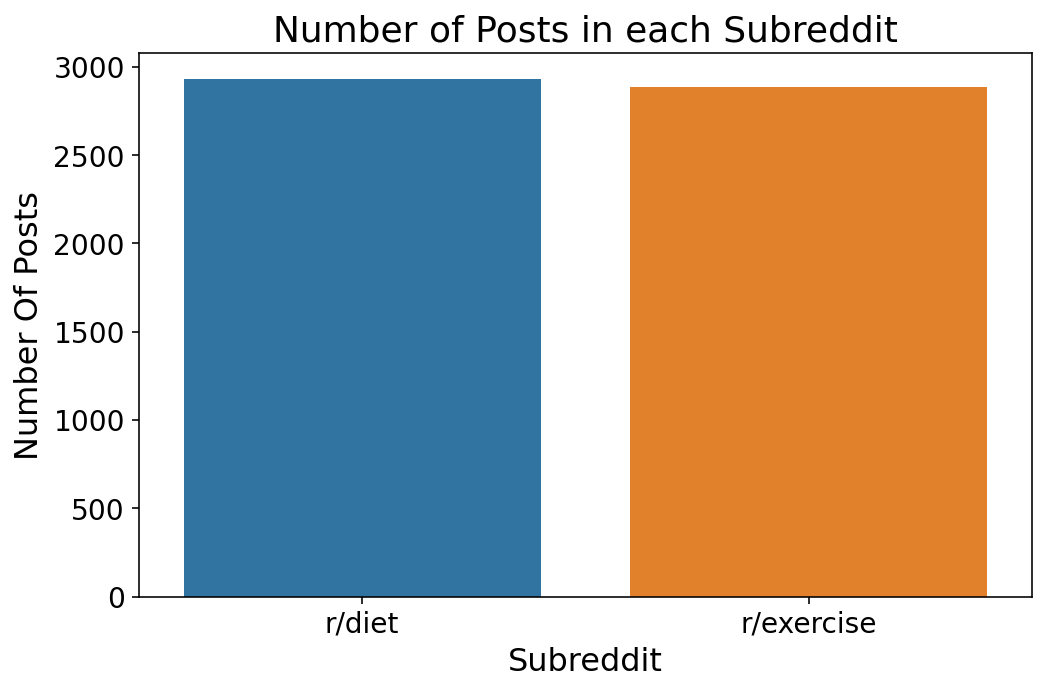

In [57]:
barplot_subreddit(df)

**Comments:**
- After cleaning, there are slightly more diet posts than exercise but the difference is not too much to cause data imbalance.

#### EDA `num_char`, `num_words`, `num_vocab`, `lexical_div`, `ave_word_length`

In [58]:
df.groupby(['subreddit']).mean()[['num_char', 'num_words', 'num_vocab', 'lexical_div', 'ave_word_length']]

num_char  num_words  num_vocab  lexical_div  ave_word_length
subreddit                                                                
0          432.444065  86.499659  54.867326     1.360202         5.103119
1          230.581282  45.618718  31.344541     1.191749         5.418194

**Comments:**
- On average, there are longer posts, more characters and more vocabulary in `diet` than `exercise`
- Also, `diet` has slightly more lexical diversity as compared to posts in `exercise`.
- `Exercise` has higher average word length as compared to `diet`

#### Distribution  Plot of Number of Characters

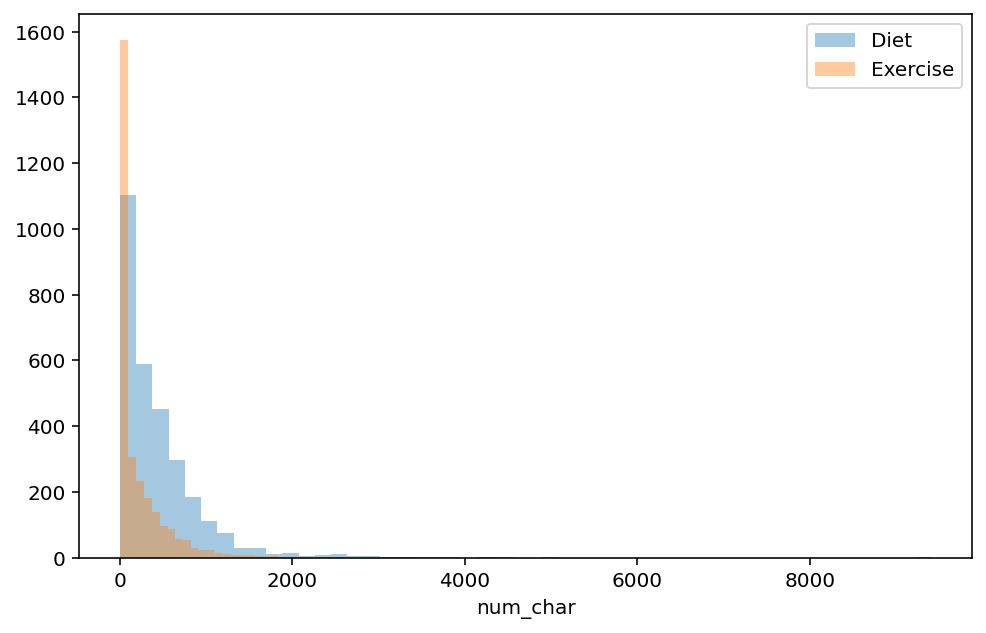

In [59]:
distribution_plot('num_char')

**Comments:**
- The distribution for number of characters in the posts is extremely skewed which suggests outliers

#### Distribution of Number of Words

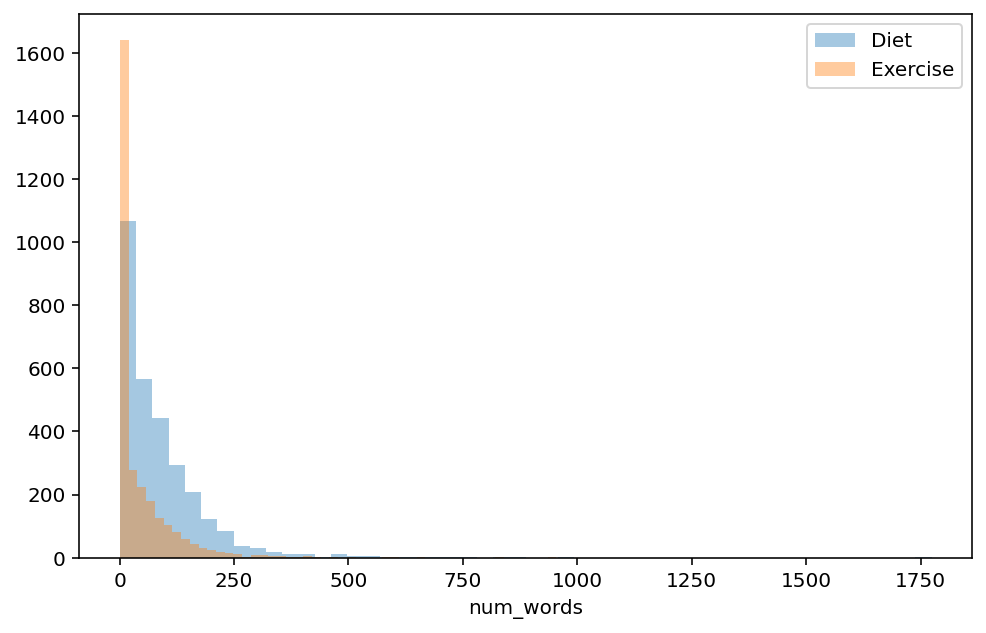

In [60]:
distribution_plot('num_words')

**Comments:**
- The distribution for number of words in the posts is extremely skewed as well which suggests outliers

#### Distribution of Number of Vocabs

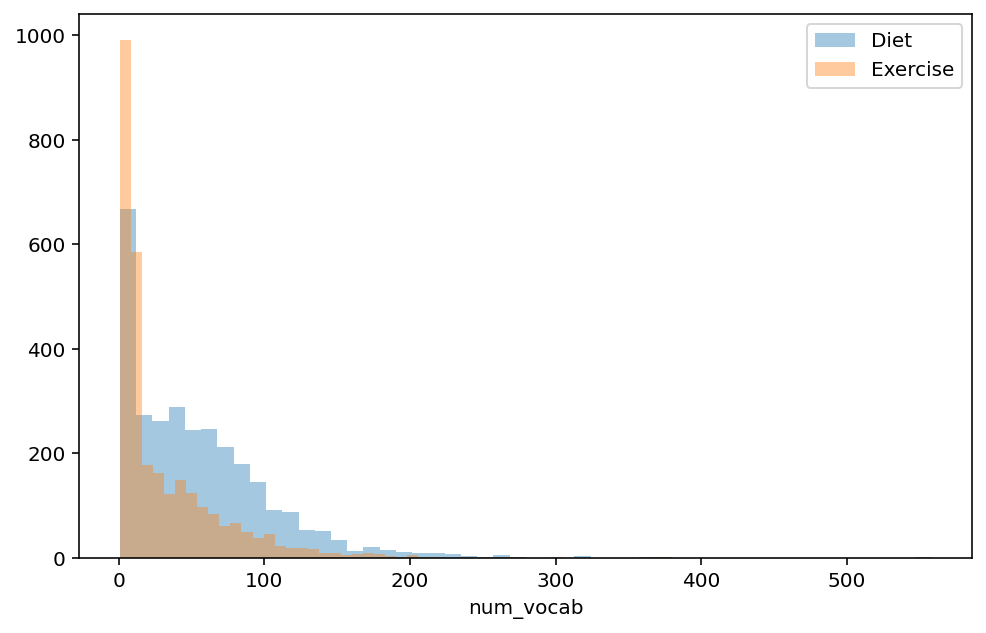

In [61]:
distribution_plot('num_vocab')

**Comments:**
- The distribution for number of vocab in the posts is extremely skewed as well which suggests outliers

#### Distribution of Lexical Diversity

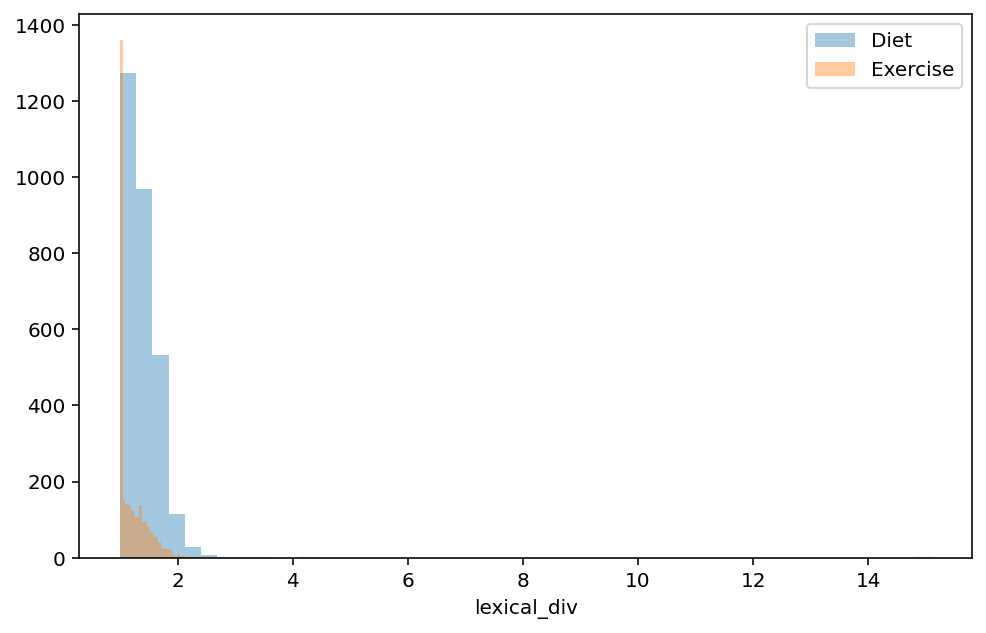

In [62]:
distribution_plot('lexical_div')

**Comments:**
- The distribution for lexical diversity in the posts is extremely skewed as well which suggests outliers

#### Distribution plot of Average Word Length

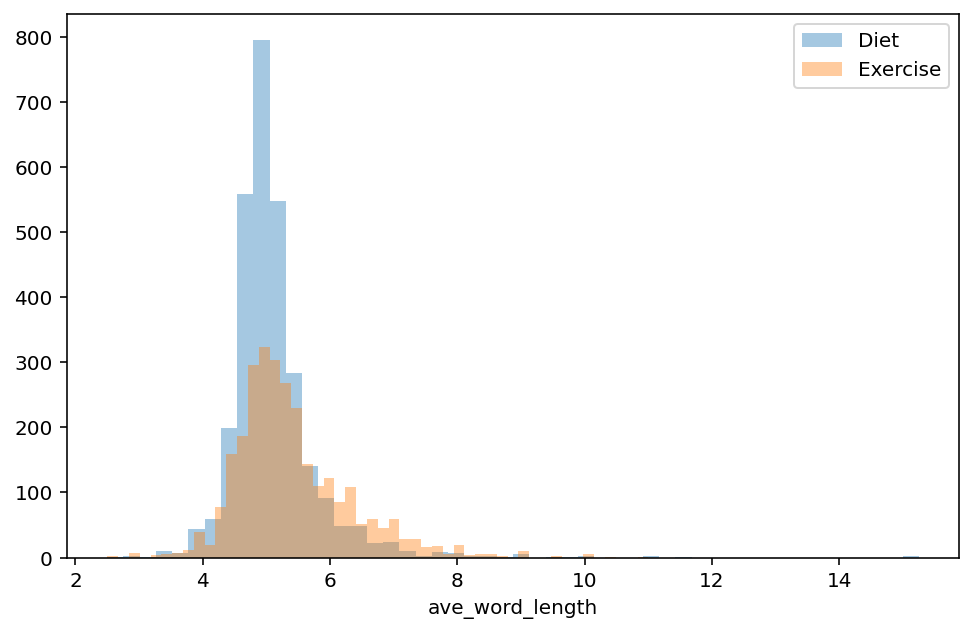

In [63]:
distribution_plot('ave_word_length')

**Comments:**
- The distribution for average word length in the posts is somewhat approximately normal with slight skew

### Common Words and Phrases
- For this analysis, I excluded stop words so as to not distort our common words and phrases analysis

100%|██████████| 2932/2932 [00:00<00:00, 3375.26it/s]


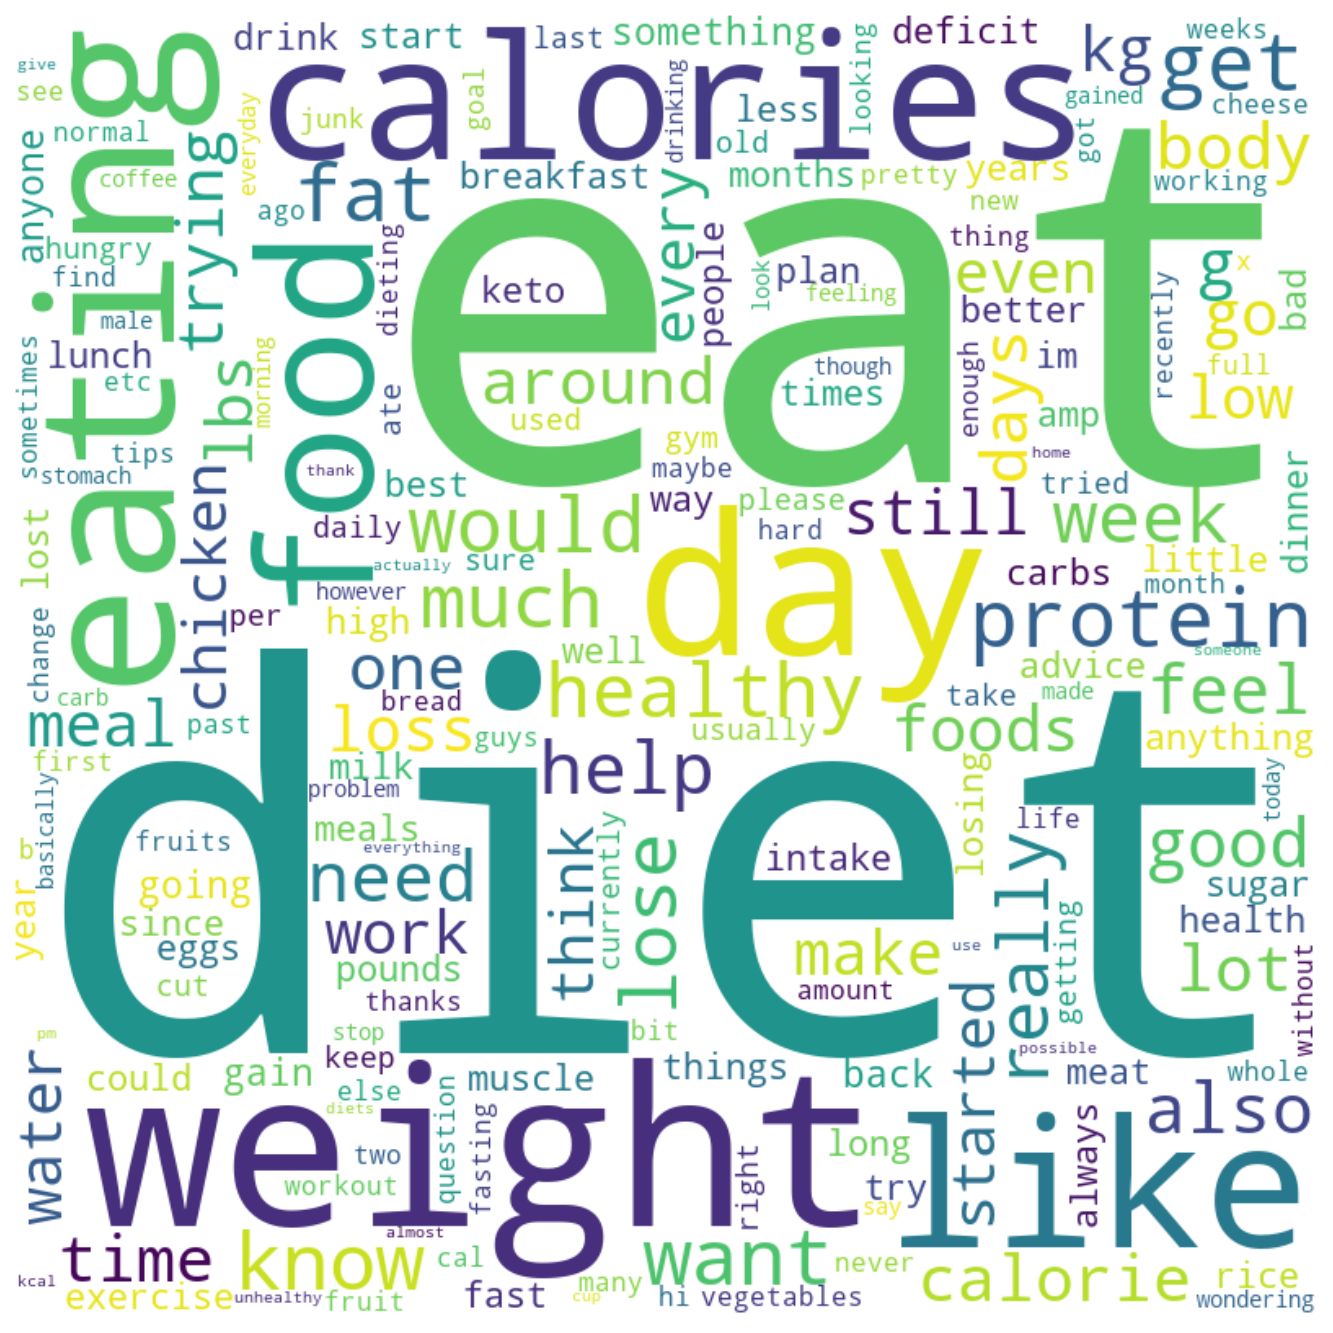

In [64]:
wordcloud(df_diet, min_freq=10)

- At a glance, I can see that common words that appear in diet posts includes weight, diet, eat, calories

100%|██████████| 2885/2885 [00:00<00:00, 5563.34it/s]


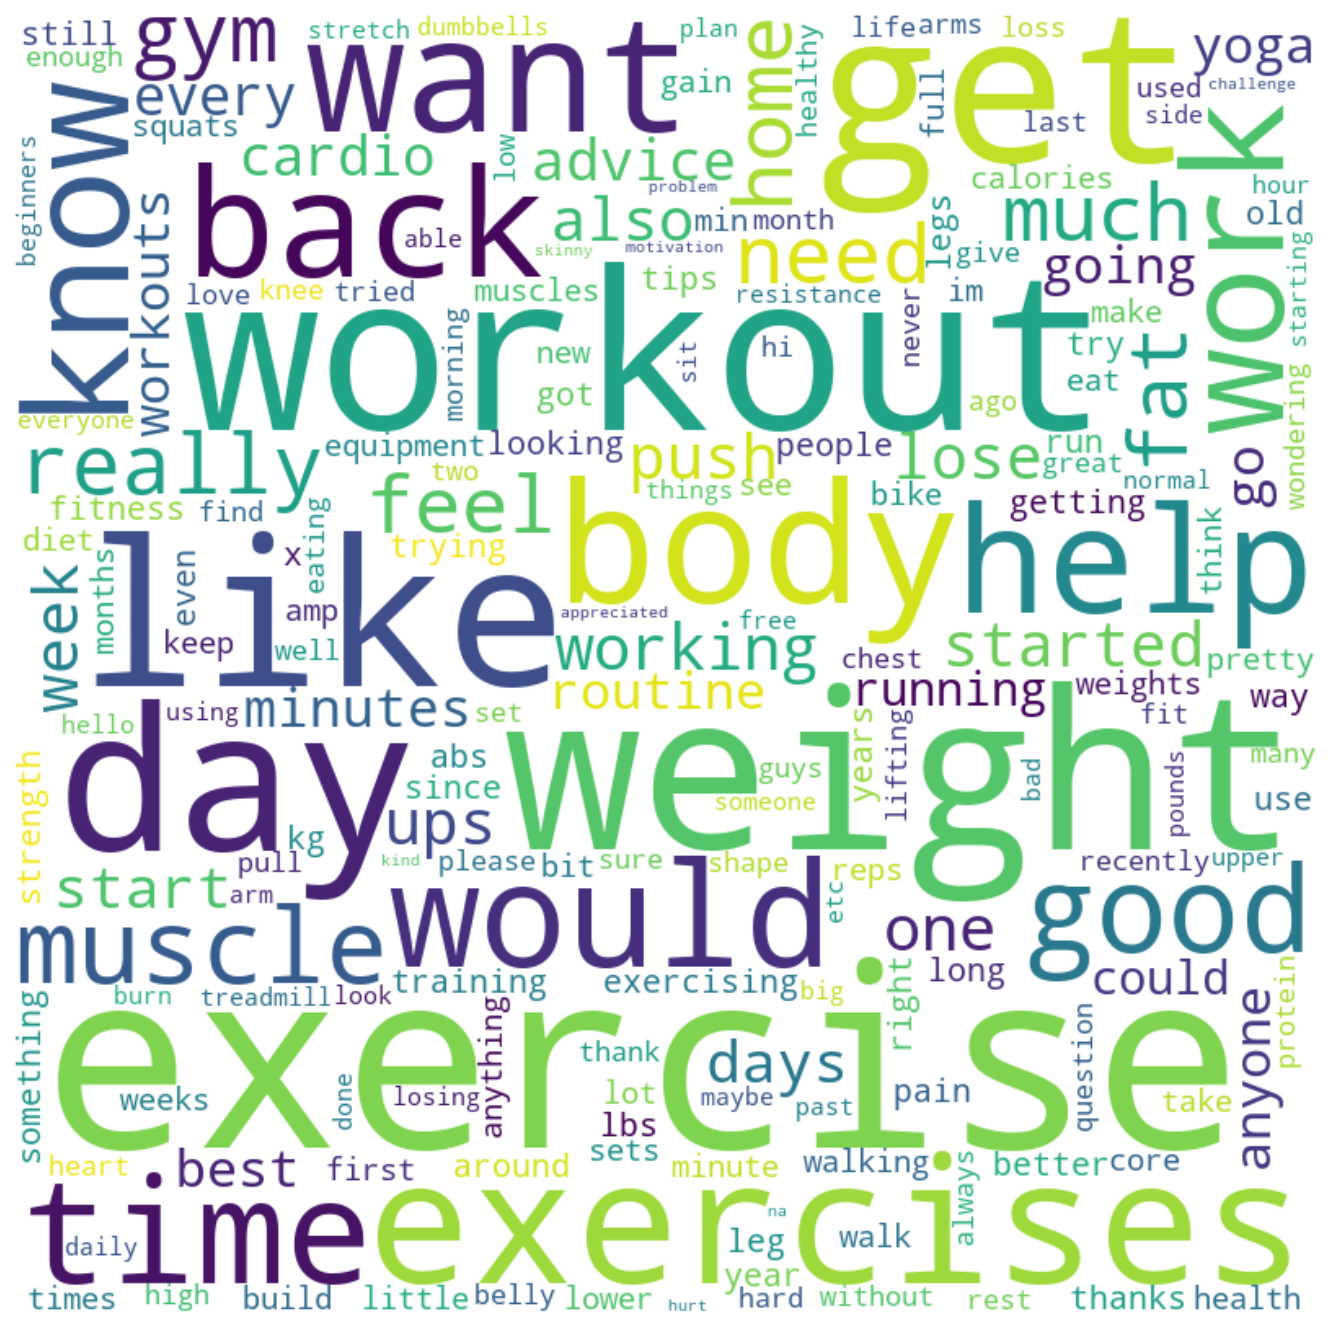

In [65]:
wordcloud(df_exercise, min_freq=10)

- As for exercise, the common words that appear includes exercise, workout, body, muscle, weight

Next, we'll see how many times these common words appear

In [66]:
# Instantiating the count vectorizer
vectorizer = CountVectorizer()

# Masking the vectorizer with English stop words
cvec_diet     = CountVectorizer(stop_words = "english")
cvec_exercise = CountVectorizer(stop_words = "english")

# Subsetting the dataframe
diet     = df[df["subreddit"] == 0]
exercise = df[df["subreddit"] == 1]

# Fit-transforming the vectorizer
vec_diet     = cvec_diet.fit_transform(df_diet["title_text_cleaned"])
vec_exercise = cvec_exercise.fit_transform(df_exercise["title_text_cleaned"])

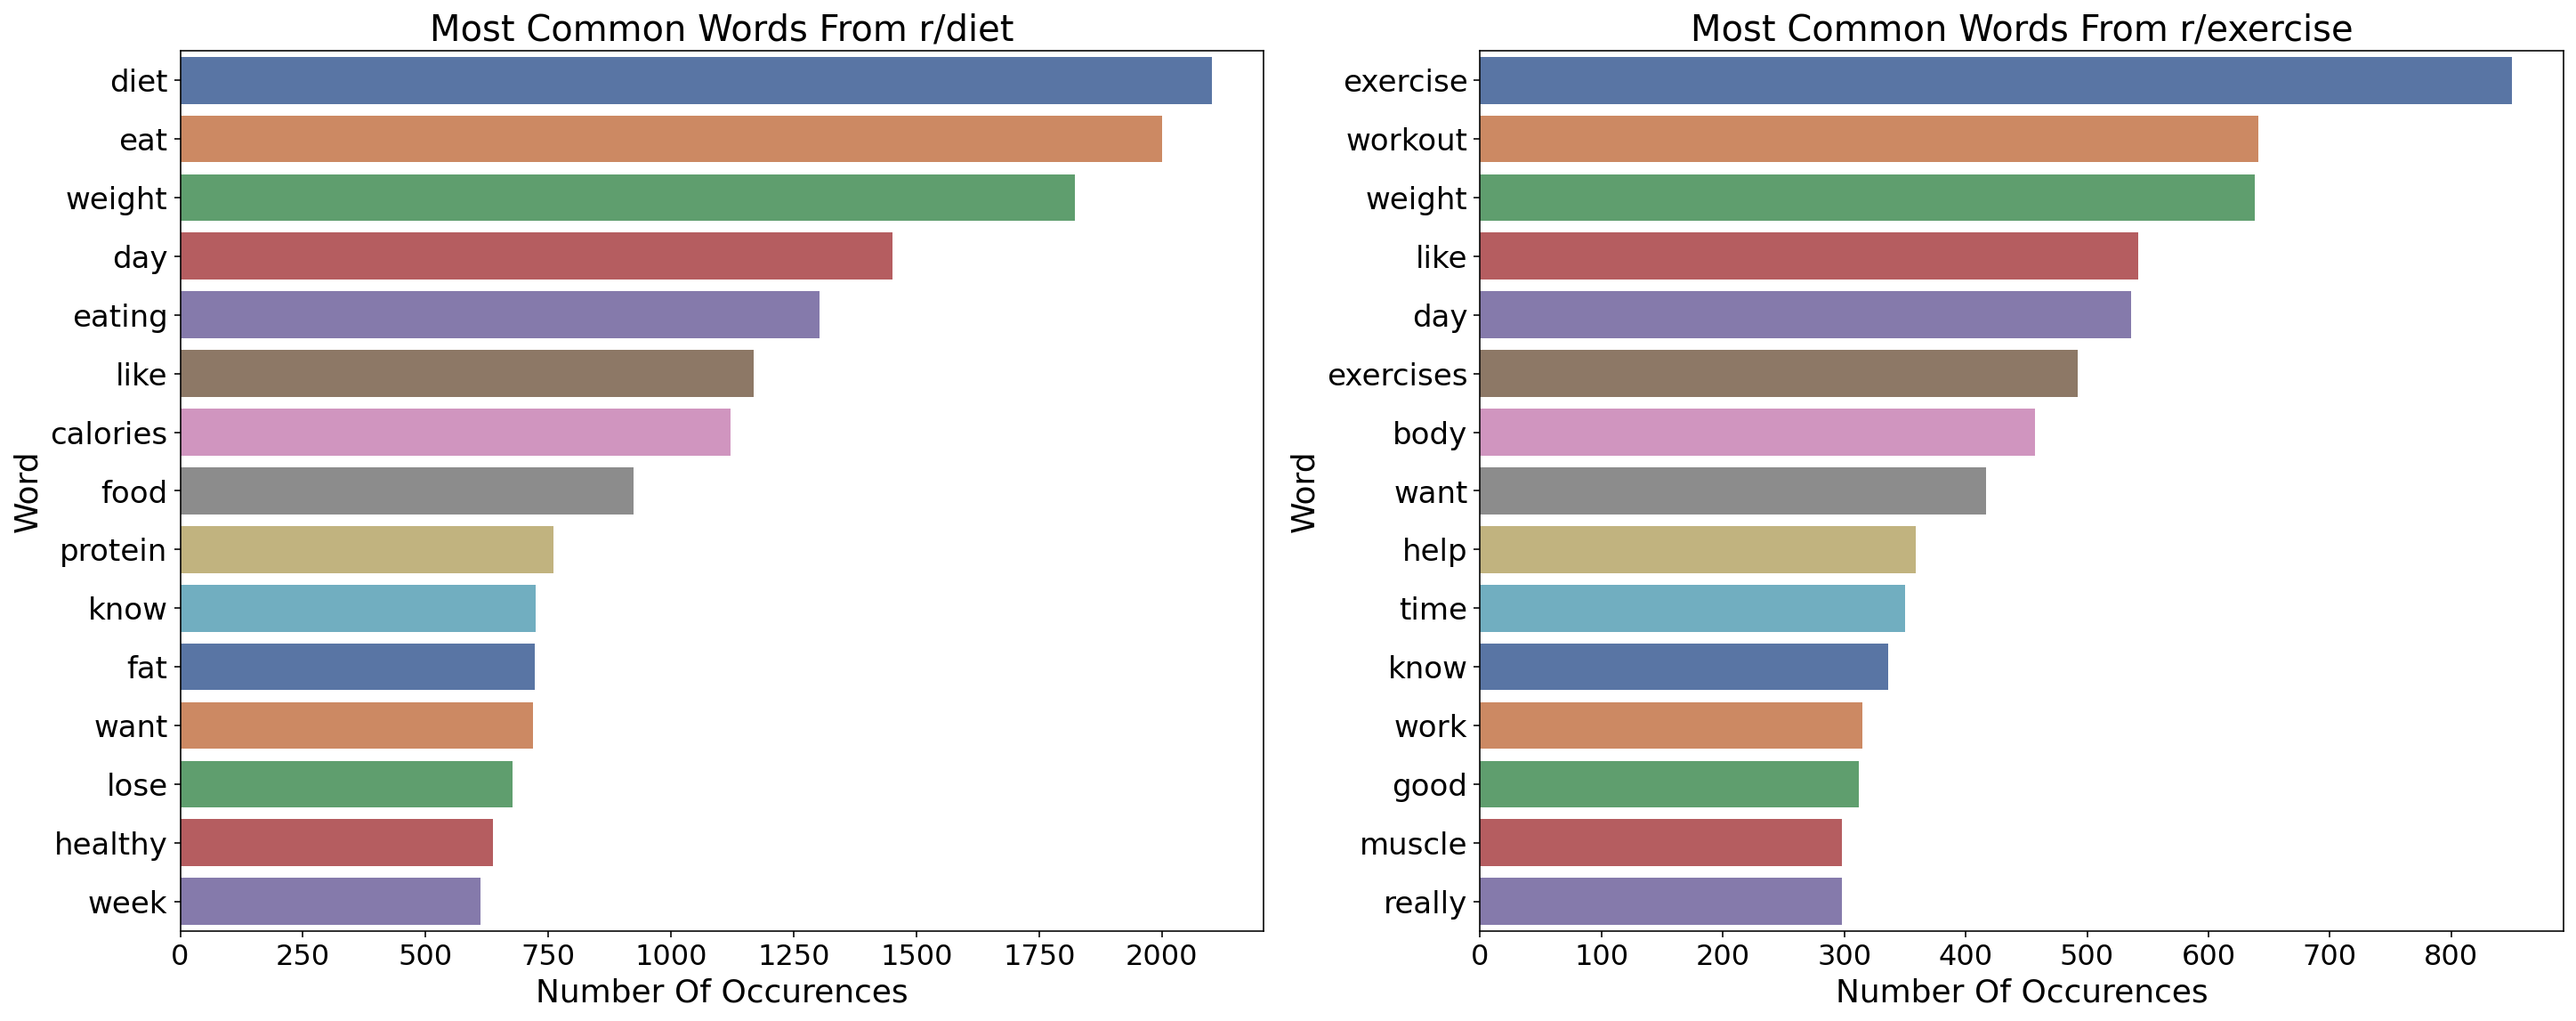

In [67]:
# Saving the vectorized dfs to a new dataframe
diet_vectorized     = pd.DataFrame(vec_diet.toarray(), columns = cvec_diet.get_feature_names())
exercise_vectorized = pd.DataFrame(vec_exercise.toarray(), columns = cvec_exercise.get_feature_names())

# Getting the 15 most frequent words from each
vectorized_diet     = pd.DataFrame(diet_vectorized.sum().sort_values(ascending = False).head(15))
vectorized_exercise = pd.DataFrame(exercise_vectorized.sum().sort_values(ascending = False).head(15))

# Plotting the most common words
plot_most_frequent_words(dataframes = [vectorized_diet, vectorized_exercise],
                         titles = ["r/diet","r/exercise"])

**Comments:**
- The word *weight* appear in the top 15 for both diet and exercise. This is not suprise as both topics are centered around weight as people go on a certain diet to achieve a desired weight and similarly, people exercise to reduce or maintain their weight. Weight also refers to the weight of gym plates.

#### Common Phrases

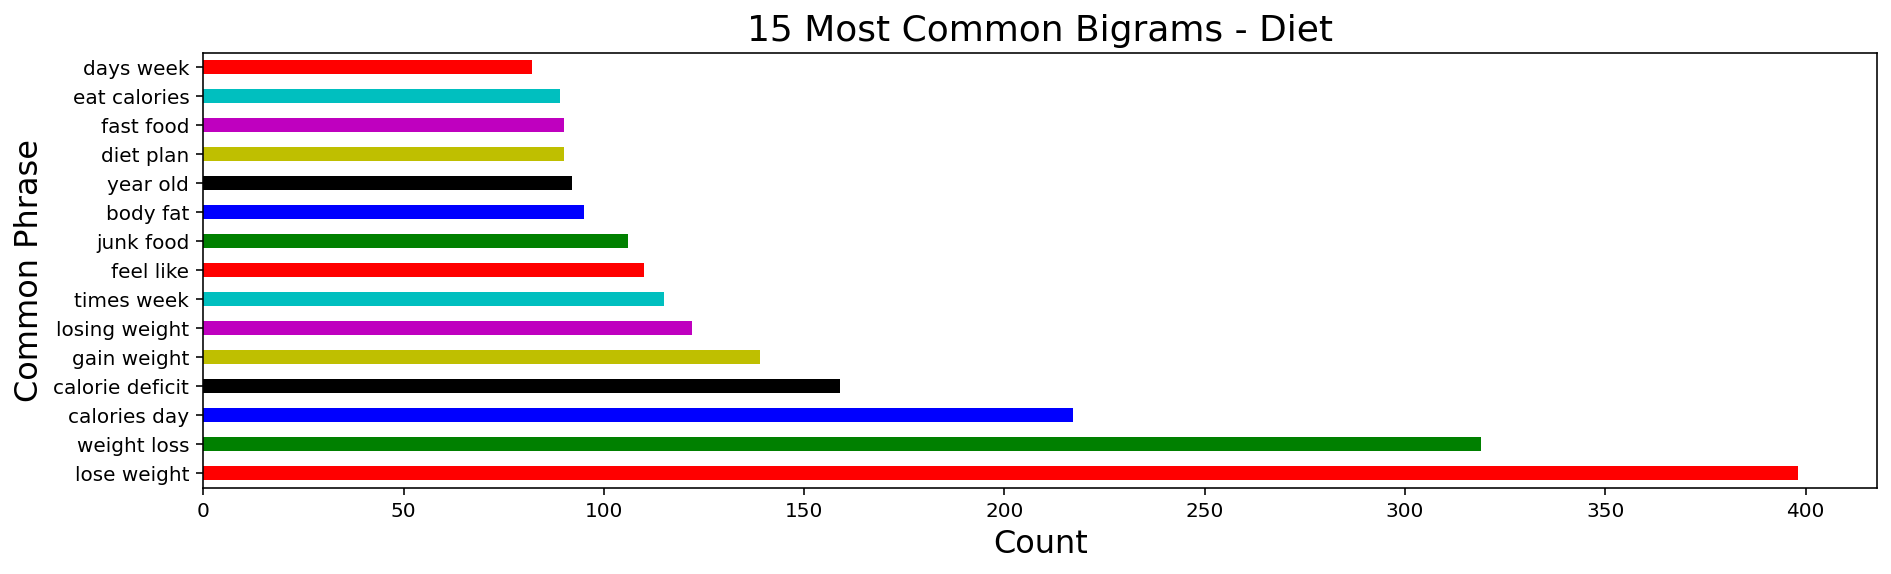

In [68]:
common_phrase(df_diet, 2,2, "15 Most Common Bigrams - Diet")

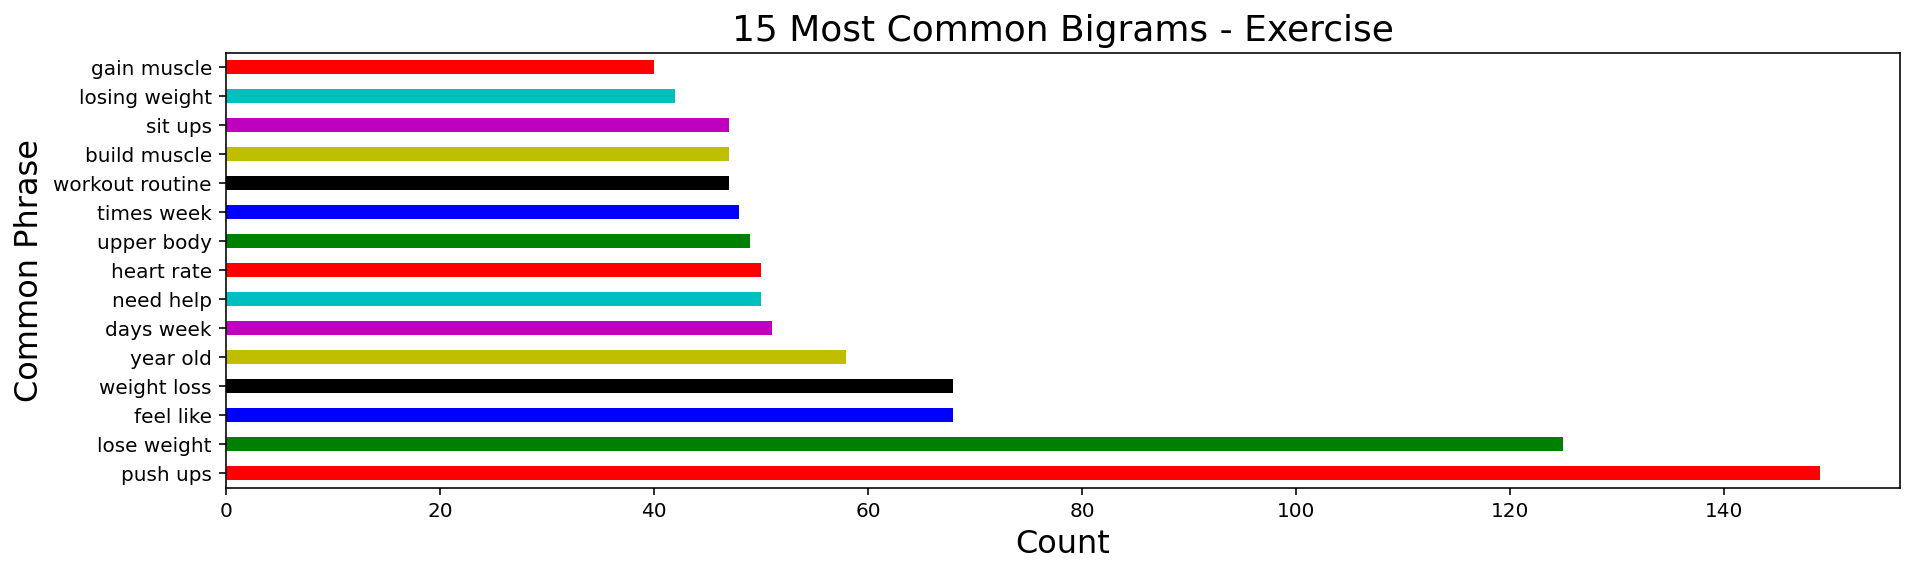

In [69]:
common_phrase(df_exercise, 2, 2, "15 Most Common Bigrams - Exercise")

**Comments:**
- *losing weight*, *lose weight*, *weight losss*, *times week*, *days week* are some of the common phrases used in the posts

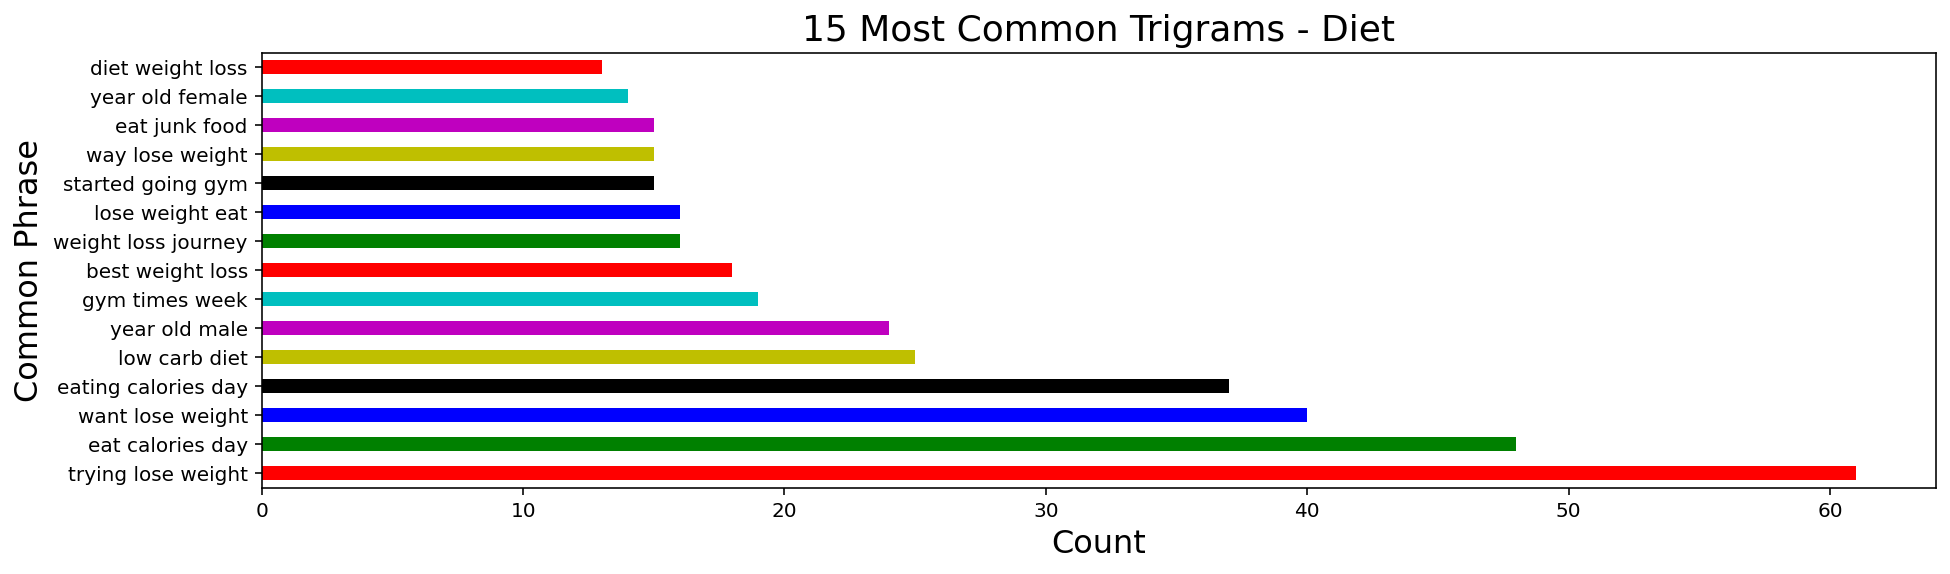

In [70]:
common_phrase(df_diet, 3,3, "15 Most Common Trigrams - Diet")

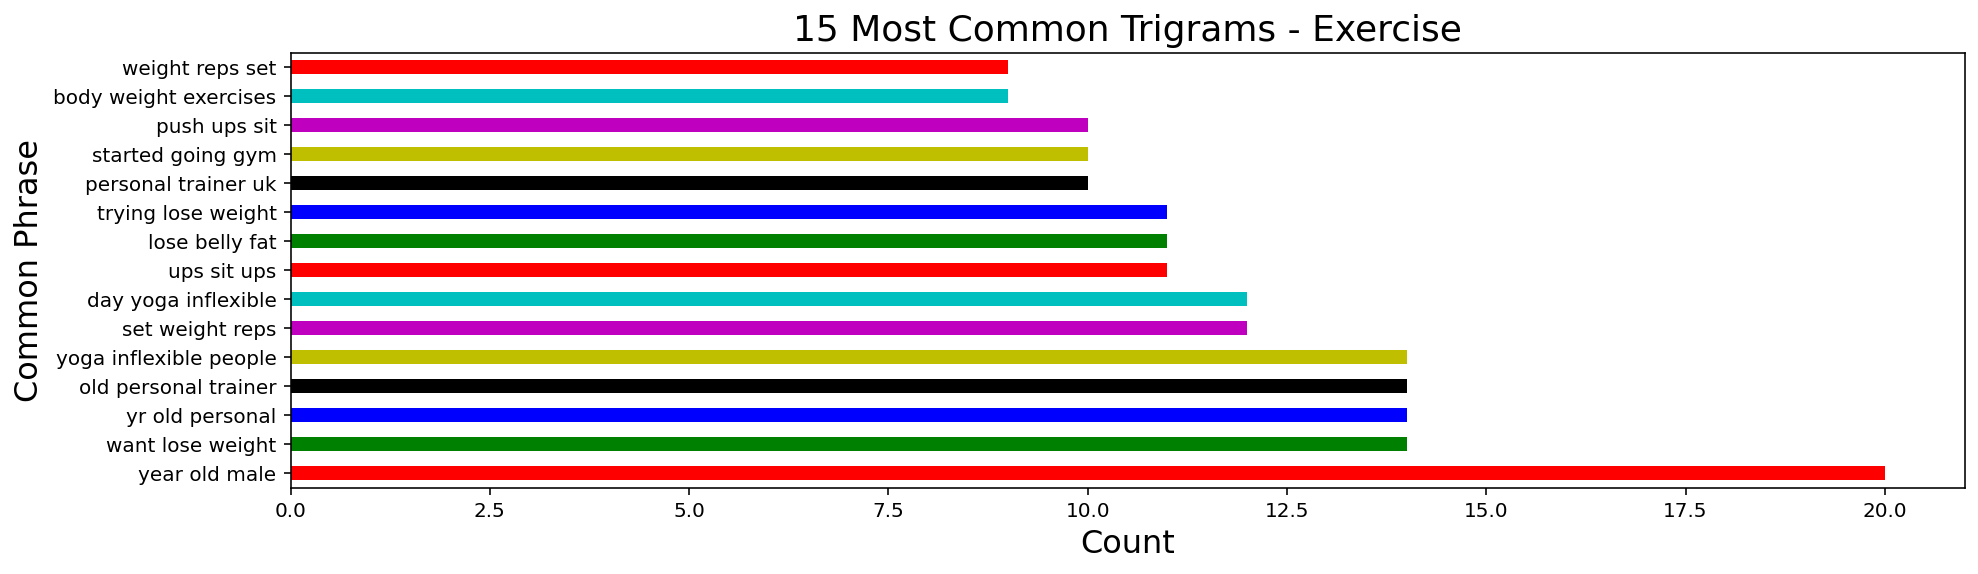

In [71]:
common_phrase(df_exercise, 3,3, "15 Most Common Trigrams - Exercise")

**Comments:**
- The trigrams phrases are mostly unique to each posts.

In [72]:
df.head()

subreddit                                 title_text_cleaned  \
0          1  exercise mediated neurogenesis hippocampus via...   
1          1     high school internet seed oils processed foods   
2          1  combining exercise goal setting greater manife...   
3          1      neuroscientist practice brain dr wendy suzuki   
4          1  time lift designing time efficient training pr...   

                   title_text_cleaned_with_stopwords  \
0  exercise mediated neurogenesis in the hippocam...   
1  high school in no internet no seed oils no pro...   
2  combining exercise with goal setting for great...   
3  neuroscientist if you practice this your brain...   
4  no time to lift designing time efficient train...   

                                     title_text_lemm  \
0  exercise mediated neurogenesis hippocampus via...   
1       high school internet seed oil processed food   
2  combining exercise goal setting greater manife...   
3      neuroscientist practice brain dr wendy suzuki   
4  time lift designing time efficient training pr...   

                      title_text_lemm_with_stopwords  num_char  num_words  \
0  exercise mediated neurogenesis in the hippocam...        58          8   
1  high school in no internet no seed oil no proc...        58         11   
2  combining exercise with goal setting for great...       124         17   
3  neuroscientist if you practice this your brain...        83         15   
4  no time to lift designing time efficient train...       106         16   

   num_vocab  lexical_div  ave_word_length  
0          8     1.000000         7.250000  
1          9     1.222222         5.272727  
2         17     1.000000         7.294118  
3         15     1.000000         5.533333  
4         15     1.066667         6.625000

### Pre-processing

In [73]:
# Calculating the baseline accuracy of getting either r/exercise or r/diet
# The ratio between r/exercise or r/diet is approximately similar (50-50)
df["subreddit"].value_counts(normalize=True)

0    0.50404
1    0.49596
Name: subreddit, dtype: float64

In [74]:
# Setting up the predictors and target variables
X = df["title_text_cleaned_with_stopwords"]
y = df["subreddit"]

In [75]:
# Train-test-split, 70-30 split.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, shuffle=True)

In [76]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4071,), (1746,), (4071,), (1746,))

In [77]:
#baseline accuracy
y_test.value_counts(normalize=True)

1    0.517182
0    0.482818
Name: subreddit, dtype: float64

## Modelling

In [78]:
def best_parameter(text_feature, model):
    #setup pipeline:
    pipe = Pipeline([
        ('tf', text_feature),
        ('mdl', model)
    ])

    #using GridSearchCV to get the most optimised tvec parameters
    params = {
        'tf__stop_words': [None, 'english'],
        'tf__ngram_range': [(1, 1), (1, 2)],
        'tf__max_df': [.85, .9, .95],
        'tf__min_df': [2, 4, 6],
        'tf__max_features': [1000, 2000, 3000],
    }
    gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1)
    gs.fit(X_train, y_train)
    
    print('best score:', gs.best_score_)
    print('best params:', gs.best_params_)

In [79]:
#evaluation metrics
def evaluation_matrix(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    #accuracy
    acc = round(((tn + tp) / (tn + fp + fn + tp)),3)
    print("Accuracy: ", acc)
    
    #specificity
    spec = round((tn / (tn + fp)),3)
    print("Specificity: ", spec)
    
    #sensitivity
    sens = round((tp / (tp + fn)),3)
    
    #recall = recall_score(y_test, y_pred)
    print("Sensitivity/Recall", sens)
    
    #precision
    prec = round((tp / (tp + fp)),3)
    #precision = precision_score(y_test, y_pred)
    print("Precision", prec)
    
    # f1 score
    print("F1 Score: ",round(f1_score(y_test, y_pred),3))

In [80]:
#Classification Metrics
def cm(y_test, y_pred):
    cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
    cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
    
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
    
    display(cm_def)
    display(cm_df)

In [81]:
# Plot confusion matrix

def plot_cm(model,X_test):
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format='d', display_labels=['diet', 'exercise']);

### Model 1: Testing of MultinomialNB with GridsearchCV TfidfVectorizer tuning

In [82]:
#find best params
best_parameter(TfidfVectorizer(), MultinomialNB())

best score: 0.9029725207639319
best params: {'tf__max_df': 0.85, 'tf__max_features': 3000, 'tf__min_df': 4, 'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}


In [83]:
#Apply MultinomialNB with optimized tvec parameters
tvec1 = TfidfVectorizer(stop_words='english', ngram_range=(
    1, 2), max_df=0.85, min_df=2, max_features=3000)

# Fit_transform our X_train dataset using the most optimal parameters
X_train_tvec1 = tvec1.fit_transform(X_train)
X_train_tvec1 = pd.DataFrame(X_train_tvec1.toarray(),
                            columns=tvec1.get_feature_names())
X_test_tvec1 = tvec1.transform(X_test)
X_test_tvec1 = pd.DataFrame(X_test_tvec1.toarray(),
                           columns=tvec1.get_feature_names())
print('TfidfVectorizer:')
print(X_train_tvec1.sum().sort_values(ascending=False)[:5])
print()

TfidfVectorizer:
weight      127.424958
diet        123.159928
exercise    101.827844
eat         101.359139
day          94.398704
dtype: float64



In [84]:
# Fitting nb1 to the optimized training data
#instatiate
nb1 = MultinomialNB()

#fit model
nb1.fit(X_train_tvec1, y_train)

#predict
y_pred1 = nb1.predict(X_test_tvec1)

print('Model accuracy on train set:', round(nb1.score(X_train_tvec1, y_train),3))
print('Model accuracy on test set:',  round(nb1.score(X_test_tvec1, y_test),3))

Model accuracy on train set: 0.93
Model accuracy on test set: 0.898


In [85]:
round(roc_auc_score(y_test, nb1.predict_proba(X_test_tvec1)[:,1]),2)

0.97

In [86]:
cm(y_test, y_pred1)

pred neg        pred pos
actual neg   True Negative  False Positive
actual pos  False Negative   True Positive

pred neg  pred pos
actual neg       793        50
actual pos       128       775

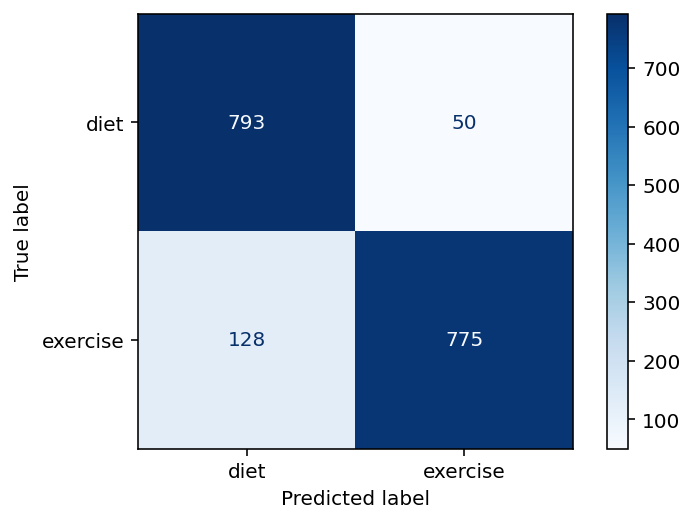

In [87]:
plot_cm(nb1,X_test_tvec1)

In [88]:
evaluation_matrix(y_test, y_pred1)

Accuracy:  0.898
Specificity:  0.941
Sensitivity/Recall 0.858
Precision 0.939
F1 Score:  0.897


### Model 2: Testing of MultinomialNB with GridsearchCV CountVectorizer tuning

In [89]:
#find best params
best_parameter(CountVectorizer(), MultinomialNB())

best score: 0.9091135195429674
best params: {'tf__max_df': 0.85, 'tf__max_features': 3000, 'tf__min_df': 2, 'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}


In [90]:
#Apply MultinomialNB with optimized cvec parameters
cvec2 = CountVectorizer(stop_words='english', ngram_range=(
    1, 1), max_df=0.85, min_df=2, max_features=3000)

# Fit_transform our X_train dataset using the most optimal parameters
X_train_cvec2 = cvec2.fit_transform(X_train)
X_train_cvec2 = pd.DataFrame(X_train_cvec2.toarray(),
                            columns=cvec2.get_feature_names())
X_test_cvec2 = cvec2.transform(X_test)
X_test_cvec2 = pd.DataFrame(X_test_cvec2.toarray(),
                           columns=cvec2.get_feature_names())
print('CountVectorizer:')
print(X_train_cvec2.sum().sort_values(ascending=False)[:5])
print()

CountVectorizer:
weight    1724
diet      1550
eat       1546
day       1389
just      1254
dtype: int64



In [91]:
# Fitting nb2 to the optimized training data
#instatiate
nb2 = MultinomialNB()

#fit model
nb2.fit(X_train_cvec2, y_train)

#predict
y_pred2 = nb2.predict(X_test_cvec2)

print('Model accuracy on train set:', round(nb2.score(X_train_cvec2, y_train),3))
print('Model accuracy on test set:', round(nb2.score(X_test_cvec2, y_test),3))

Model accuracy on train set: 0.928
Model accuracy on test set: 0.907


In [92]:
round(roc_auc_score(y_test, nb2.predict_proba(X_test_cvec2)[:,1]),2)

0.97

In [93]:
cm(y_test, y_pred2)

pred neg        pred pos
actual neg   True Negative  False Positive
actual pos  False Negative   True Positive

pred neg  pred pos
actual neg       783        60
actual pos       103       800

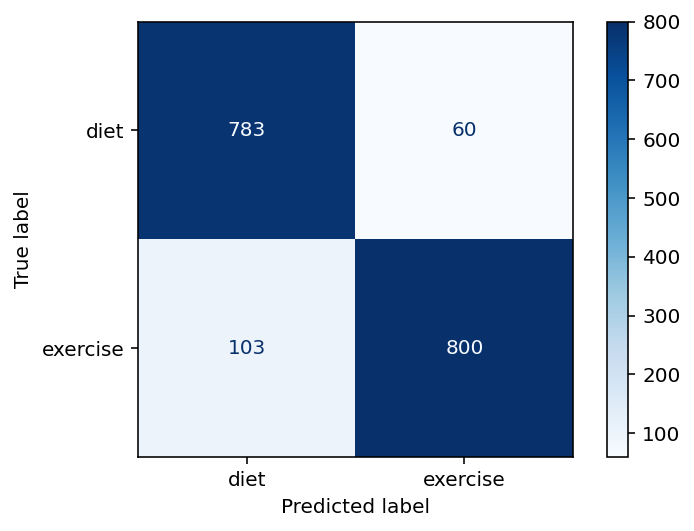

In [94]:
plot_cm(nb2,X_test_cvec2)

In [95]:
evaluation_matrix(y_test, y_pred2)

Accuracy:  0.907
Specificity:  0.929
Sensitivity/Recall 0.886
Precision 0.93
F1 Score:  0.908


In [96]:
X_test_cvec2.head()

aajonus  ab  abdomen  ability  able  abs  absolute  absolutely  absorb  \
0        0   0        0        0     0    0         0           0       0   
1        0   0        0        0     0    0         0           0       0   
2        0   0        0        0     0    0         0           0       0   
3        0   0        0        0     0    0         0           0       0   
4        0   0        0        0     0    0         0           0       0   

   abt  ac  academic  access  accident  accidentally  accomplish  according  \
0    0   0         0       0         0             0           0          0   
1    0   0         0       0         0             0           0          0   
2    0   0         0       0         0             0           0          0   
3    0   0         0       0         0             0           0          0   
4    0   0         0       0         0             0           0          0   

   account  accountable  accurate  ache  aches  achieve  aching  acid  acne  \
0        0            0         0     0      0        0       0     0     0   
1        0            0         0     0      0        0       0     0     0   
2        0            0         0     0      0        0       0     0     0   
3        0            0         0     0      0        0       0     0     0   
4        0            0         0     0      0        0       0     0     0   

   act  active  actively  activities  activity  actual  actually  add  added  \
0    0       0         0           0         0       0         0    0      0   
1    0       0         0           0         0       0         0    0      0   
2    0       0         0           0         0       0         0    0      0   
3    0       0         0           0         1       0         0    0      0   
4    0       0         0           0         0       0         0    1      0   

   addicted  addiction  adding  addition  additional  adds  adequate  adhd  \
0         0          0       0         0           0     0         0     0   
1         0          0       0         0           0     0         0     0   
2         0          0       0         0           0     0         0     0   
3         0          0       0         0           0     0         0     0   
4         0          0       0         0           0     0         0     0   

   adjust  adjustable  adjusting  admin  admit  adult  adults  advance  \
0       0           0          0      0      0      0       0        0   
1       0           0          0      0      0      0       0        0   
2       0           0          0      0      0      0       0        0   
3       0           0          0      0      0      0       1        0   
4       0           0          0      0      0      0       0        0   

   advanced  advice  advise  aerobic  affect  affected  affecting  affects  \
0         0       0       0        0       0         0          0        0   
1         0       0       0        0       0         0          0        0   
2         0       0       0        0       0         0          0        0   
3         0       0       0        0       0         0          0        0   
4         0       0       0        0       0         0          0        0   

   afford  affordable  afraid  afternoon  afterward  age  aged  agility  ago  \
0       0           0       0          0          0    0     0        0    0   
1       0           0       0          0          0    0     0        0    0   
2       0           0       0          0          0    0     0        0    0   
3       0           0       0          0          0    0     0        0    0   
4       0           0       0          0          0    0     0        0    0   

   ahead  ai  aid  aim  aiming  ain  air  alcohol  allergic  allergies  \
0      0   0    0    0       0    0    0        0         0          0   
1      0   0    0    0       0    0    0        0         0          0   
2      0   0    0    0 

### Model 3: Testing of RandomForestClassifier with GridsearchCV TfidfVectorizer tuning

In [97]:
best_parameter(TfidfVectorizer(), RandomForestClassifier())

best score: 0.9054256040759109
best params: {'tf__max_df': 0.9, 'tf__max_features': 3000, 'tf__min_df': 4, 'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}


In [98]:
#Apply RandomForestClassifier with optimized tvec parameters
tvec3 = TfidfVectorizer(stop_words='english', ngram_range=(
    1, 1), max_df=0.85, min_df=4, max_features=3000)

# Fit_transform our X_train dataset using the most optimal parameters
X_train_tvec3 = tvec3.fit_transform(X_train)
X_train_tvec3 = pd.DataFrame(X_train_tvec3.toarray(),
                            columns=tvec3.get_feature_names())
X_test_tvec3 = tvec3.transform(X_test)
X_test_tvec3 = pd.DataFrame(X_test_tvec3.toarray(),
                           columns=tvec3.get_feature_names())
print('TfidfVectorizer:')
print(X_train_tvec3.sum().sort_values(ascending=False)[:5])
print()

TfidfVectorizer:
weight      144.044791
diet        136.862565
eat         111.459719
day         103.171679
exercise    103.168158
dtype: float64



In [99]:
# Fitting nb to the optimized training data
#instatiate
rf3 = RandomForestClassifier()

#fit model
rf3.fit(X_train_tvec3, y_train)

#predict
y_pred3 = rf3.predict(X_test_tvec3)

print('Model accuracy on train set:', round(rf3.score(X_train_tvec3, y_train),3))
print('Model accuracy on test set:', round(rf3.score(X_test_tvec3, y_test),3))

Model accuracy on train set: 0.997
Model accuracy on test set: 0.879


In [100]:
round(roc_auc_score(y_test, rf3.predict_proba(X_test_tvec3)[:,1]),2)

0.95

In [101]:
cm(y_test, y_pred3)

pred neg        pred pos
actual neg   True Negative  False Positive
actual pos  False Negative   True Positive

pred neg  pred pos
actual neg       758        85
actual pos       126       777

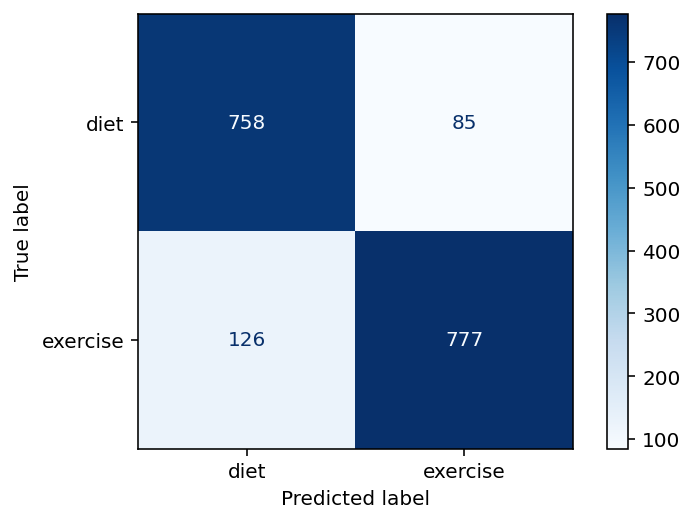

In [102]:
plot_cm(rf3,X_test_tvec3)

In [103]:
evaluation_matrix(y_test, y_pred3)

Accuracy:  0.879
Specificity:  0.899
Sensitivity/Recall 0.86
Precision 0.901
F1 Score:  0.88


### Model 4: Testing of RandomForestClassifier with GridsearchCV CountVectorizer tuning

In [104]:
best_parameter(CountVectorizer(), RandomForestClassifier())

best score: 0.9012480969536183
best params: {'tf__max_df': 0.9, 'tf__max_features': 3000, 'tf__min_df': 6, 'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}


In [105]:
#Apply MultinomialNB with optimized cvec parameters
cvec4 = CountVectorizer(stop_words='english', ngram_range=(
    1, 2), max_df=0.85, min_df=2, max_features=3000)

# Fit_transform our X_train dataset using the most optimal parameters
X_train_cvec4 = cvec4.fit_transform(X_train)
X_train_cvec4 = pd.DataFrame(X_train_cvec4.toarray(),
                            columns=cvec4.get_feature_names())
X_test_cvec4 = cvec4.transform(X_test)
X_test_cvec4 = pd.DataFrame(X_test_cvec4.toarray(),
                           columns=cvec4.get_feature_names())
print('CountVectorizer:')
print(X_train_cvec4.sum().sort_values(ascending=False)[:5])
print()

CountVectorizer:
weight    1724
diet      1550
eat       1546
day       1389
just      1254
dtype: int64



In [106]:
# Fitting nb to the optimized training data
#instatiate
rf4 = RandomForestClassifier()

#fit model
rf4.fit(X_train_cvec4, y_train)

#predict
y_pred4 = rf4.predict(X_test_cvec4)

print('Model accuracy on train set:', round(rf4.score(X_train_cvec4, y_train),3))
print('Model accuracy on test set:', round(rf4.score(X_test_cvec4, y_test),3))

Model accuracy on train set: 0.996
Model accuracy on test set: 0.877


In [107]:
round(roc_auc_score(y_test, rf4.predict_proba(X_test_cvec4)[:,1]),2)

0.95

In [108]:
cm(y_test, y_pred4)

pred neg        pred pos
actual neg   True Negative  False Positive
actual pos  False Negative   True Positive

pred neg  pred pos
actual neg       764        79
actual pos       136       767

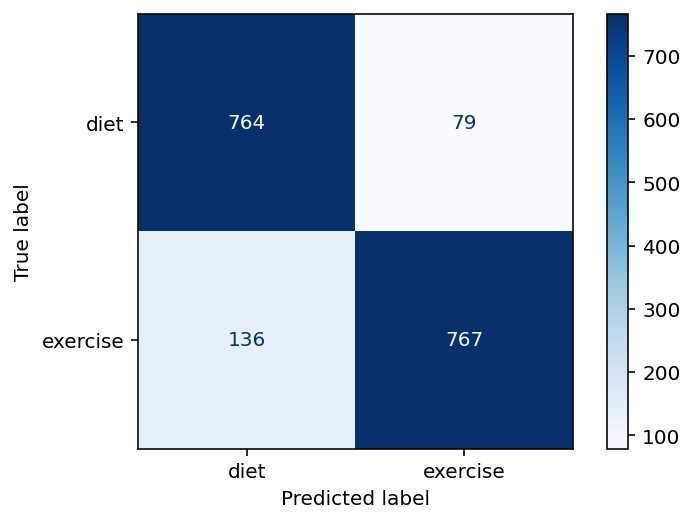

In [109]:
plot_cm(rf4,X_test_cvec4)

In [110]:
evaluation_matrix(y_test, y_pred4)

Accuracy:  0.877
Specificity:  0.906
Sensitivity/Recall 0.849
Precision 0.907
F1 Score:  0.877


### Model 5: Testing of LogisticRegression with GridsearchCV TfidfVectorizer tuning

In [111]:
best_parameter(TfidfVectorizer(), LogisticRegression())

best score: 0.9191824060535717
best params: {'tf__max_df': 0.85, 'tf__max_features': 3000, 'tf__min_df': 2, 'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}


In [112]:
#Apply RandomForestClassifier with optimized tvec parameters
tvec5 = TfidfVectorizer(stop_words='english', ngram_range=(
    1, 2), max_df=0.85, min_df=2, max_features=3000)

# Fit_transform our X_train dataset using the most optimal parameters
X_train_tvec5 = tvec5.fit_transform(X_train)
X_train_tvec5 = pd.DataFrame(X_train_tvec5.toarray(),
                            columns=tvec5.get_feature_names())
X_test_tvec5 = tvec5.transform(X_test)
X_test_tvec5 = pd.DataFrame(X_test_tvec5.toarray(),
                           columns=tvec5.get_feature_names())
print('TfidfVectorizer:')
print(X_train_tvec5.sum().sort_values(ascending=False)[:5])
print()

TfidfVectorizer:
weight      127.424958
diet        123.159928
exercise    101.827844
eat         101.359139
day          94.398704
dtype: float64



In [113]:
# Fitting nb to the optimized training data
#instatiate
lr5 = LogisticRegression()

#fit model
lr5.fit(X_train_tvec5, y_train)

#predict
y_pred5 = lr5.predict(X_test_tvec5)

print('Model accuracy on train set:', round(lr5.score(X_train_tvec5, y_train),3))
print('Model accuracy on test set:', round(lr5.score(X_test_tvec5, y_test),3))

Model accuracy on train set: 0.95
Model accuracy on test set: 0.913


In [114]:
round(roc_auc_score(y_test, lr5.predict_proba(X_test_tvec5)[:,1]),2)

0.97

In [115]:
cm(y_test, y_pred5)

pred neg        pred pos
actual neg   True Negative  False Positive
actual pos  False Negative   True Positive

pred neg  pred pos
actual neg       765        78
actual pos        74       829

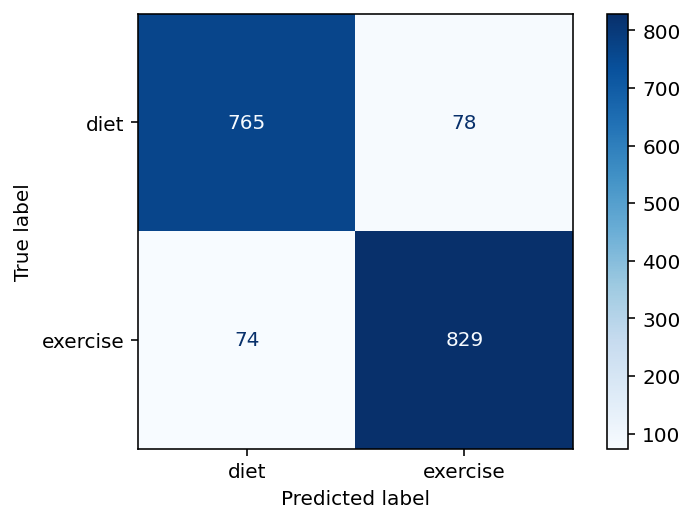

In [116]:
plot_cm(lr5,X_test_tvec5)

In [117]:
evaluation_matrix(y_test, y_pred5)

Accuracy:  0.913
Specificity:  0.907
Sensitivity/Recall 0.918
Precision 0.914
F1 Score:  0.916


### Model 6: Testing of LogisticRegression with GridsearchCV CountVectorizer tuning

In [118]:
best_parameter(CountVectorizer(), LogisticRegression())

best score: 0.9049351080025927
best params: {'tf__max_df': 0.85, 'tf__max_features': 3000, 'tf__min_df': 6, 'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}


In [119]:
#Apply MultinomialNB with optimized cvec parameters
cvec6 = CountVectorizer(stop_words='english', ngram_range=(
    1, 2), max_df=0.85, min_df=6, max_features=3000)

# Fit_transform our X_train dataset using the most optimal parameters
X_train_cvec6 = cvec6.fit_transform(X_train)
X_train_cvec6 = pd.DataFrame(X_train_cvec6.toarray(),
                            columns=cvec6.get_feature_names())
X_test_cvec6 = cvec6.transform(X_test)
X_test_cvec6 = pd.DataFrame(X_test_cvec6.toarray(),
                           columns=cvec6.get_feature_names())
print('CountVectorizer:')
print(X_train_cvec6.sum().sort_values(ascending=False)[:5])
print()

CountVectorizer:
weight    1724
diet      1550
eat       1546
day       1389
just      1254
dtype: int64



In [120]:
# Fitting lr to the optimized training data
#instantiate
lr6 = LogisticRegression()

#fit model
lr6.fit(X_train_cvec6, y_train)

#predict
y_pred6 = lr6.predict(X_test_cvec6)

print('Model accuracy on train set:', round(lr6.score(X_train_cvec6, y_train),3))
print('Model accuracy on test set:', round(lr6.score(X_test_cvec6, y_test),3))

Model accuracy on train set: 0.971
Model accuracy on test set: 0.901


In [121]:
round(roc_auc_score(y_test, lr6.predict_proba(X_test_cvec6)[:,1]),2)

0.96

In [122]:
cm(y_test, y_pred6)

pred neg        pred pos
actual neg   True Negative  False Positive
actual pos  False Negative   True Positive

pred neg  pred pos
actual neg       738       105
actual pos        67       836

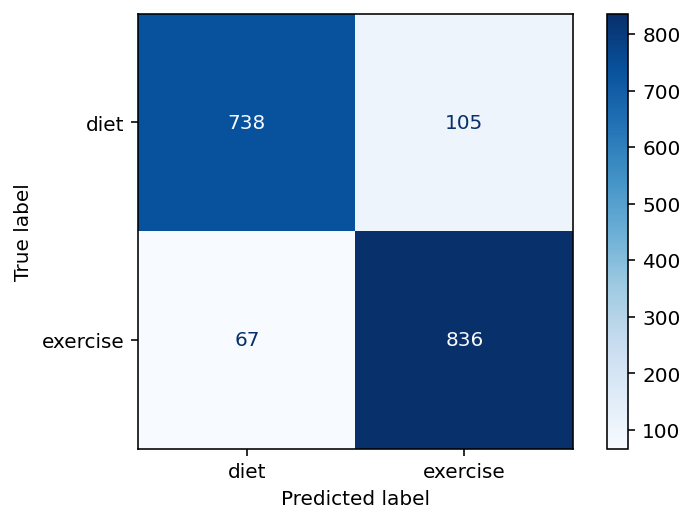

In [123]:
plot_cm(lr6,X_test_cvec6)

In [124]:
evaluation_matrix(y_test, y_pred6)

Accuracy:  0.901
Specificity:  0.875
Sensitivity/Recall 0.926
Precision 0.888
F1 Score:  0.907


## Evaluation

### Analysis of classification results

|Model|Train Accuracy|Test Accuracy|Generalisation|ROC AUC|True Positive|True Negative|False Positive|False Negative|Percision|Recall|
|---|---|---|---|---|---|---|---|---|---|---|
|TVEC/MultinomialNB|0.93|0.898|3.2%|0.97|775|793|50|128|0.939|0.858|
|CVEC/MultinomialNB|0.928|0.907|2.1%|0.97|800|783|60|103|0.93|0.886|
|TVEC/RandomForestClassifier|0.997|0.88|11.7%|0.95|776|760|83|127|0.903|0.859|
|CVEC/RandomForestClassifier|0.996|0.878|11.8%|0.95|774|759|84|129|0.902|0.857|
|TVEC/LogReg|0.95|0.913|3.1%|0.97|829|765|78|74|0.914|0.918|
|CVEC/LogReg|0.971|0.901|7%|0.96|836|738|105|67|0.888|0.926|

**Comments:**
- Based on test accuracy and AUC ROC scores, it appears that CVEC/MultinomialNB model performed the out of the six. The model is not as overfit as the rest. 

- However, I were to build a classification model that would recommend posts based on search input, my model should have minimal false positive(posts that weren't relevant) and false negative(not passing along useful content) while optimising precision and recall. This can also be seen in CVEC/MultinomialNB although there are other model that scored just slightly better.

- Sensitivity/Recall: Of all the posts that were truly "diet", how many did we label? For this, we have recall value of 0.886 which is good for this model. 

- Percision: Of all the post labelled as "diet", how many are actually diet? This precision rate relates to the low false positive rate. In this case, we have got 0.93 precision which is very good! 

### Generate ROC Curves

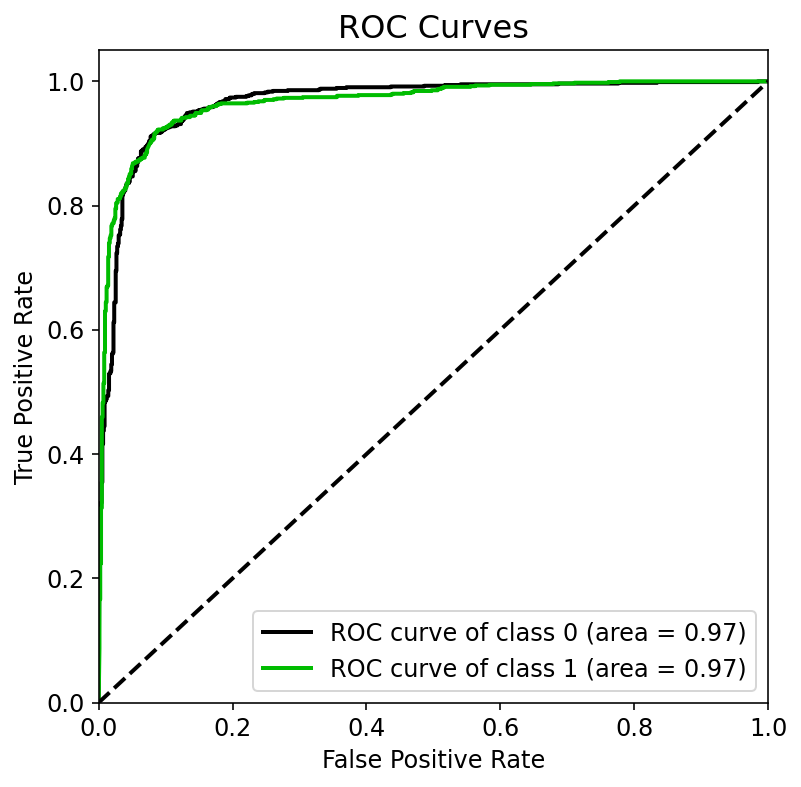

In [124]:
# Ground truth labels (y_test)
y_true = y_test

# Predicted probabilities generated by sklearn classifier (y_hat)
y_probas = nb2.predict_proba(X_test_cvec2)

skplt.metrics.plot_roc(y_true, y_probas,
                       plot_macro=False,
                       plot_micro=False,
                       figsize=(6,6),
                       title_fontsize=16,
                       text_fontsize=12)
plt.show()
# Class 0 is r/diet
# Class 1 is r/exercise

**Comments:**
- Our CVEC/NB model is able to achieve ROC/AOC of 97% for both r/diet and r/exercise. This means that our model is good at classifying the posts between the two subreddits. 

### The most important words that distinguishes between r/diet and r/exercise

In [125]:
# Saving the MNB coefficients
nb2_coefficients = pd.Series(nb2.coef_[0])   # To create 1D array

In [126]:
# Saving the vocabulary list and word count
vocab_train2 = cvec2.get_feature_names()

In [127]:
# Creating a dataframe of vocabulary and their coefficients
key_classifier_words = pd.DataFrame([vocab_train2, nb2_coefficients],
                                    index=["words", "nb2_coeff"]).T
key_classifier_words.head(10)

words nb2_coeff
0     aajonus  -10.5572
1          ab  -7.37916
2     abdomen  -8.94778
3     ability  -9.45861
4        able  -6.70707
5         abs  -5.88439
6    absolute  -8.61131
7  absolutely  -8.15932
8      absorb  -10.5572
9         abt  -9.17092

In [128]:
# Transforming the natural log
key_classifier_words["coeffs"] = key_classifier_words["nb2_coeff"].apply(lambda x: np.exp(x))

In [129]:

key_classifier_words = key_classifier_words.sort_values(by=["coeffs"], ascending=False)

In [130]:
# Top 10 r/exercise words
key_classifier_words.head(10)

words nb2_coeff    coeffs
913    exercise  -4.18561  0.015213
2960    workout    -4.475  0.011390
1409       just  -4.57077  0.010350
2916     weight  -4.59879  0.010064
2844         ve  -4.69075  0.009180
1500       like  -4.70789  0.009024
915   exercises  -4.71949  0.008920
681         day  -4.76726  0.008504
287        body  -4.86686  0.007698
794       doing  -4.90123  0.007437

In [131]:
# Top 10 r/diet words
key_classifier_words.tail(10).sort_values(by=["coeffs"], ascending=True)

words nb2_coeff    coeffs
285             bmr  -10.5572  0.000026
282     blueberries  -10.5572  0.000026
645          crisps  -10.5572  0.000026
281            blue  -10.5572  0.000026
2559        studies  -10.5572  0.000026
1851  participation  -10.5572  0.000026
1850    participate  -10.5572  0.000026
1849   participants  -10.5572  0.000026
275           bloat  -10.5572  0.000026
0           aajonus  -10.5572  0.000026

In [132]:
# creating index of feature names
index = cvec2.get_feature_names()

In [133]:
# making df of features w/coefs
nb_coef_df = pd.DataFrame(nb2.coef_[0],
                         columns=["coef"],
                         index=index)
# sorting for highest coef
nb_coef_df = nb_coef_df.sort_values("coef", ascending=False)
nb_coef_df.head()

coef
exercise -4.185606
workout  -4.474999
just     -4.570766
weight   -4.598793
ve       -4.690750

In [134]:
# isolating top and bottom coefs
nb_coef_odds = pd.concat(objs=[nb_coef_df.head(10), nb_coef_df.tail(10)])

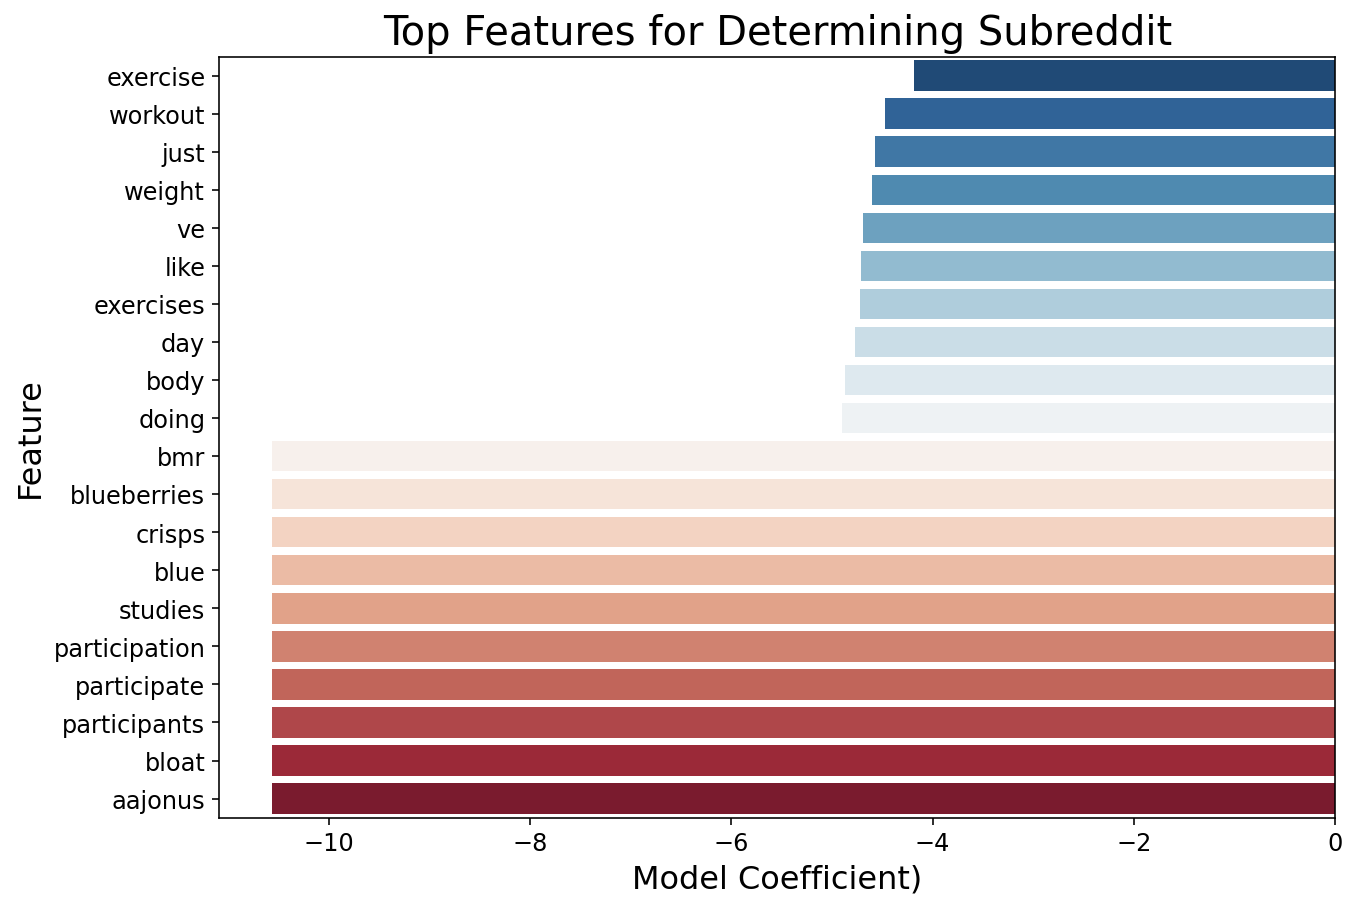

In [135]:
# plotting most significant coefs
plt.figure(figsize=(10, 7))
sns.barplot(data=nb_coef_odds,
            x="coef",
            y=nb_coef_odds.index,
            palette="RdBu_r")
plt.title("Top Features for Determining Subreddit", size=20)
plt.yticks(size=12)
plt.xticks(size=12)
plt.ylabel("Feature", size=16)
plt.xlabel("Model Coefficient)", size=16);

**Comments:**
- Words and hargons unique to topic post: "ve" = ventilation, "bmr" = basal metabolic rate, "aajonus" = American alternative nutritionist and food-rights activist who focused on raw foods

#### False Positive Posts

In [125]:
false_positives = X_test[(y_test == 0) & (y_pred2 == 1)]
false_positives.head(10)

2937    in need of a diet plan hi i have been trying t...
3384    need advice tips hey guys so i ve recently sta...
4118                                       just wondering
3830    i m skinny fat can i do a body recomp while do...
5250    yoga for weight loss the latest ten successes ...
3383    ok fat loss tips here are my best ones and wha...
5690    heeey listen up so excited to share this with ...
5300        effective ways to lose weight and live longer
3555    next steps for weight loss hello i m looking t...
5070    how diets for heart health can help you improv...
Name: title_text_cleaned_with_stopwords, dtype: object

In [128]:
# Printing the first 5 false-positive posts (i.e r/diet classified as r/exercise)
# Using the row indexes
for i in [2937, 3384, 4118, 3830, 5250, 5070]:
    print(f'#{i} {false_positives[i]}\n')

#2937 in need of a diet plan hi i have been trying to loose weight for months now and even did a bit but i was only doing workouts i wasn t controlling my diet as such but i think now is the time when i need to do it i have months to prove my gf was wrong so i am kgs rn and i am i workout days a week push pull legs push pull legs each workout goes around hrs with mins of gap between every set i know i am lazy i see changes in my muscle growth fat decreasing but i feel like its not at a good amount so wanna try out eating healthy now but i honestly have no previous experience or clue with this so i come to reddit for help

#3384 need advice tips hey guys so i ve recently started my weight loss journey i m currently and pounds i want to lose at least pounds by september but i m afraid that just like the previous times i ve tried to lose weight it won t work and i ll lose like pounds my diet right now is mainly low calorie i try to maintain a calorie intake a day never over a i workout ev

**Comments:**
These are  strong feature words of r/exercise that appear have been misclassfied

- #2937:  "weight", "workouts"
- #3384: "Cardio"
- #3830: "body"
- #5250: "weight"

## Conclusion & Recommendations

Conclusion:

- For this problem, I was tasked with building a classification model that could accurately distinguish posts from the r/diet from the r/exercise Subreddit. The best-performing model was a CVEC Naive Bayes with an accuracy of 90.7% and a sensitivity of 88.6%. This model is good at accurately predicting posts from the r/exercise. However, we should try to improve the overall accuracy score.


Recommendation:
- To begin the next round of improvements, we will learn from our models and manually prune features from the vector of words. Once the dimensionality of the models has been reduced, we will be able to tune our models in hopes of improving the overall accuracy.

- Beyond easing the burden of moderators by giving them the ability to classify posts from two different subreddits based on their title and selftext, there are several other possible applications for this model.

- By looking at the probabilities associated with each post, moderators can also understand the overall direction of their subreddit. It's often hard to trace the evolution of subreddits over time, however, by looking at the posts that have an extremely high classification probability (>0.99), moderators can see the language and topics that have become characteristic or emblematic of their community.

- Depending on their objectives, moderators can then try to increase the diversity of topics within their subreddit, or try to attempt to refocus conversations that are straying from the vision and objectives of the subreddit.